### Websites to Scrape:
1. https://app.powerbi.com/view?r=eyJrIjoiZGNhZGIwM2QtYTM2NC00ZjRiLTliNmMtZjdiMGQ2ZDRjYjg2IiwidCI6IjM4MmZiOGIwLTRkYzMtNDEwNy04MGJkLTM1OTViMjQzMmZhZSIsImMiOjZ9
2. 

In [1]:
from requests import get
import requests
from bs4 import BeautifulSoup
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
import datetime
import pandas as pd
import us
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy
import warnings
warnings.filterwarnings("ignore")

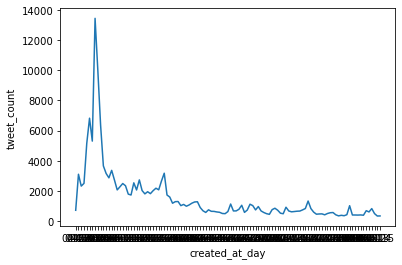

In [3]:
from shapely.geometry import box
from shapely.geometry import Point

country = "Colombia"
tweets_df = pd.read_csv(f"../data/raw/processed/tweets_df_fs_{country}.csv").drop_duplicates(subset="tweet_id")
tweets_df_2 = pd.read_csv(f"../data/raw/processed/tweets_df_fs_{country}_07_08.csv").drop_duplicates(subset="tweet_id")
tweets_df = pd.concat([tweets_df, tweets_df_2])

tweets_df['place_bbox'][tweets_df.place_bbox.isna()==False] = tweets_df.place_bbox[tweets_df.place_bbox.isna()==False].apply(lambda x: [float(idx) for idx in x.strip("[]").split(",")])
tweets_df['coordinates'][tweets_df.coordinates.isna()==False] = tweets_df.coordinates[tweets_df.coordinates.isna()==False].apply(lambda x: [float(idx) for idx in x.strip("POINT ()").split(" ")])

tweets_df['coords_from_place'] = np.NaN
tweets_df['coords_from_place'][tweets_df.place_bbox.isna()==False] = tweets_df.place_bbox[tweets_df.place_bbox.isna()==False].apply(lambda x: box(*x).centroid)
tweets_df['coordinates'][tweets_df.coordinates.isna()==False] = tweets_df.coordinates[tweets_df.coordinates.isna()==False].apply(lambda x: Point(x))

tweets_df['coords_comb'] = np.NaN
tweets_df['coords_comb'][tweets_df.coordinates.isna()==False] = tweets_df['coordinates'][tweets_df.coordinates.isna()==False]
tweets_df['coords_comb'][tweets_df['coordinates'].isna()==True] = tweets_df['coords_from_place'][tweets_df['coordinates'].isna()==True]

# tweets_geo = gpd.GeoDataFrame(tweets_df, geometry=tweets_df.coords_comb, crs={'init': 'epsg:4269'})
tweets_geo = gpd.GeoDataFrame(tweets_df, geometry=tweets_df.coords_comb, crs={'init': 'epsg:4326'})
tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
tweets_geo['tweet_count'] = 1
tweets_geo['created_at_day'] = tweets_geo['created_at'].dt.strftime('%m-%d')

# fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = tweets_geo.groupby('created_at_day').sum().reset_index(), x = 'created_at_day', y = 'tweet_count')

In [4]:
# tweet data
# tweets_geo = gpd.read_file("../data/raw/processed/tweets_gdf_fs.geojson")
# protest data
date = "jul30"
df_p = pd.read_excel(f"../data/raw/protests/LatinAmerica_2018-2021_{date}.xlsx")

# groups = ["BLM: Black Lives Matter", "NAN: National Action Network", "African American Group", "NAACP", "BSU: Black Student Union", 
#           "NABPP", "SURJ", "APSP: African People's Socialist Party", "Black Fist Coalition", "Black, Young, And Educated", "Black Panthers",
#           "CCBP: Chesapeake Coalition of Black Pastors", "NABPP: New Afrikan Black Panther Party", "Black Leaders Movement LNK", 
#           "Black Unity", "RBPP: Revolutionary Black Panther Party", "BU: Black Unity", "Black Horse Militia", 
#           "APSP: African People's Socialist Party", "RAM: Revolutionary Abolitionist Movement", "NFAC: Not Fucking Around Coalition"]

# state_vote = pd.read_csv("../data/raw/processed/state_vote_stats.csv")
# df_p = pd.read_excel('../USA_2020_2021_Feb12.xlsx')
df_p['protest_count'] = 1
df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'])
df_p = df_p[
#     (df_p.stack().str.contains('|'.join(groups)).any(level=0))&
     ((df_p.EVENT_TYPE=="Protests")|(df_p.EVENT_TYPE=="Riots"))&
     (df_p['EVENT_DATE']> "2021-04-20")&(df_p.COUNTRY=="Colombia")]

# https://data.humdata.org/dataset/colombia-administrative-boundaries-levels-0-3
# state_abbrv = gpd.read_file("../data/raw/us_admin/us_abbrv.csv") #https://worldpopulationreview.com/states/state-abbreviations
# state_pop = gpd.read_file("../data/raw/us_admin/nst-est2019-alldata.csv") #https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
state_geo = gpd.read_file("../data/raw/co_admin/col_admbnda_adm1_mgn_20200416.shp")[["ADM1_ES", "geometry"]].rename(columns={"ADM1_ES":"STUSPS"})
# state_pop['POPESTIMATE2019'] = pd.to_numeric(state_pop['POPESTIMATE2019'])
# state_pop = pd.merge(state_pop, state_abbrv, left_on="NAME", right_on='State')[['Code', 'POPESTIMATE2019']]

In [23]:
# tweets_geo.groupby('created_at_day').sum().reset_index()

In [24]:
# df_p_t = pd.merge(state_tweets_time, df_p, on=["date"])
# # state_tp_time["date"] = state_tp_time.date.astype("str").str[:7]
# # state_tp_time = pd.merge(state_tp_time.groupby(["state", "date"], as_index=False).sum(), state_pop, left_on ="state", right_on="Code").drop("Code", axis=1)

# # state_tp_time['tweets_100k'] = (pd.to_numeric(state_tp_time['tweet_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000
# # state_tp_time['protests_100k'] = (pd.to_numeric(state_tp_time['protest_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000

# # add time lagg
# for lag in range(1, 8):  
#     state_tp_time[f'protest_count_lag{lag}'] = state_tp_time['protest_count'].shift(+lag)
#     state_tp_time[f'tweet_count_lag{lag}'] = state_tp_time['tweet_count'].shift(+lag)

In [131]:
# state_protests_stat = pd.merge(df_p.groupby('ADMIN1', as_index=False).sum()[['ADMIN1', 'protest_count']].rename(columns={"ADMIN1":"State"}), state_abbrv, on="State")[["Code", "protest_count"]].rename(columns={"Code":"state"})

In [134]:
# pd.merge(state_tweets_stat, state_protests_stat, on = "state")

In [138]:
# state_tweets_stat = state_tweets_stat.drop("POPESTIMATE2019_y", axis=1).rename(columns={"POPESTIMATE2019_x": "POPESTIMATE2019"})

In [234]:
# # tweets_geo['state'] = tweets_geo['location_cl'].str.split(",").str[-1].str.strip(" ")
# # tweets_geo['tweet_count'] = 1
# # state_tweets_stat = tweets_geo.groupby("state").sum().reset_index()[['state', 'tweet_count']]
# # state_geo = state_geo.to_crs(tweets_geo.crs)

# state_tweets_stat = gpd.sjoin(tweets_geo.dropna(subset=["geometry"])[['tweet_count', 'geometry']], state_geo, how="inner").groupby("STUSPS", as_index=False).sum()[['STUSPS', "tweet_count"]]
# state_tweets_stat.columns = ['state', 'tweet_count']
# state_protests_stat = pd.merge(df_p.groupby('ADMIN1', as_index=False).sum()[['ADMIN1', 'protest_count']].rename(columns={"ADMIN1":"State"}), state_abbrv, on="State")[["Code", "protest_count"]].rename(columns={"Code":"state"})

# state_tweets_stat = pd.merge(state_tweets_stat, state_pop, left_on= "state", right_on="Code").drop("Code", axis=1)
# state_tweets_stat = pd.merge(state_tweets_stat, state_protests_stat, on = "state")

# state_tweets_stat = pd.merge(state_tweets_stat, state_vote, on = "state")
# state_tweets_stat.POPESTIMATE2019 = pd.to_numeric(state_tweets_stat.POPESTIMATE2019)

# state_tweets_stat['tweets_100k'] = (pd.to_numeric(state_tweets_stat['tweet_count'])/pd.to_numeric(state_tweets_stat['POPESTIMATE2019']))*100000
# state_tweets_stat['protests_100k'] = (pd.to_numeric(state_tweets_stat['protest_count'])/pd.to_numeric(state_tweets_stat['POPESTIMATE2019']))*100000

# state_tp_stat_all = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").sum().reset_index()[['state', "count"]], on="state")
# state_tp_stat_all['2016_2020_turnout_change'] = (state_tp_stat_all['total_votes_2020'] - state_tp_stat_all['total_votes_2016'])/state_tp_stat_all['total_votes_2016']

# state_tp_stat_pass = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Adopted', 'Enacted'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
# state_tp_stat_fail = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Failed', 'Vetoed'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
# state_tp_stat_out = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").mean().reset_index()[['state', "tot_policies", "tot_failed", "tot_success", "tot_outcome"]], on="state")
# state_tp_stat_out['policy_success_rate'] = state_tp_stat_out['tot_success']/state_tp_stat_out['tot_outcome']
# state_tp_stat_out['policy_failure_rate'] = state_tp_stat_out['tot_failed']/state_tp_stat_out['tot_outcome']
# state_tp_stat_out['success_cat'] = ""
# state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']>=state_tp_stat_out['policy_success_rate'].mean()] = "More Successful Policies"
# state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']<state_tp_stat_out['policy_success_rate'].mean()] = "More Failed Policies"

In [8]:
%%time
# state tweets/protests over time
# gdf_p = gpd.GeoDataFrame(df_p[df_p['EVENT_DATE'] < "2021-07-08"], geometry=gpd.points_from_xy(df_p.LONGITUDE, df_p.LATITUDE), crs={'init': 'epsg:4326'})
gdf_p = gpd.GeoDataFrame(df_p, geometry=gpd.points_from_xy(df_p.LONGITUDE, df_p.LATITUDE), crs={'init': 'epsg:4326'})
state_protests_time = gpd.sjoin(gdf_p, state_geo, how="inner").groupby(["STUSPS", "EVENT_DATE"], as_index=False).sum().rename(columns={"EVENT_DATE":"date", "STUSPS":"state"})[['state', 'date', "protest_count"]]

state_tweets_time = gpd.sjoin(tweets_geo[tweets_geo.geometry.type == 'Point'], state_geo, how="inner").groupby(["STUSPS", "created_at_day"], as_index=False).sum().rename(columns={"created_at_day":"date", "STUSPS":"state"})[['state', 'date', "tweet_count"]]
state_tweets_time['date'] = pd.to_datetime("2021-"+state_tweets_time['date'])

# state_protests_time = pd.merge(df_p[df_p['EVENT_DATE'] < "2021-07-08"].rename(columns={"ADMIN1":"state"}), state_geo.rename(columns={"STUSPS":"state"}), on="state").rename(columns={"EVENT_DATE":"date"}).groupby(['state', 'date'], as_index=False).sum()[['state', "date", 'protest_count']]

Wall time: 1min 46s


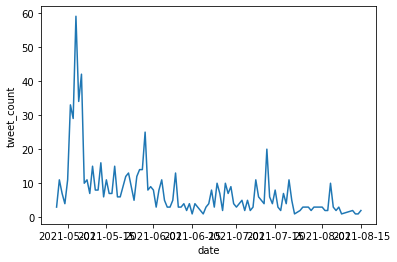

In [9]:
sns.lineplot(data = state_tweets_time[state_tweets_time['state']=='Bolívar'], x="date", y="tweet_count")

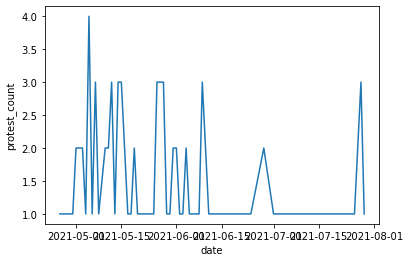

In [10]:
sns.lineplot(data = state_protests_time[state_protests_time['state']=='Bolívar'], x="date", y="protest_count")

In [13]:
state_tp_time = pd.merge(state_tweets_time, state_protests_time, on=["state", "date"])
# state_tp_time["date"] = state_tp_time.date.astype("str").str[:7]
# state_tp_time = pd.merge(state_tp_time.groupby(["state", "date"], as_index=False).sum(), state_pop, left_on ="state", right_on="Code").drop("Code", axis=1)

# state_tp_time['tweets_100k'] = (pd.to_numeric(state_tp_time['tweet_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000
# state_tp_time['protests_100k'] = (pd.to_numeric(state_tp_time['protest_count'])/pd.to_numeric(state_tp_time['POPESTIMATE2019']))*100000

# add time lagg
for lag in range(1, 8):  
    state_tp_time[f'protest_count_lag{lag}'] = state_tp_time['protest_count'].shift(+lag)
    state_tp_time[f'tweet_count_lag{lag}'] = state_tp_time['tweet_count'].shift(+lag)
    
state_tp_time.to_csv(f"../data/raw/processed/state_tp_time_{country}.csv")

In [7]:
state_tp_time = pd.read_csv("../data/raw/processed/state_tp_time.csv")

In [18]:
# sns.scatterplot(data = state_tp_time[state_tp_time['state']=="Bogotá, D.C."], x="tweet_count", y="protest_count")

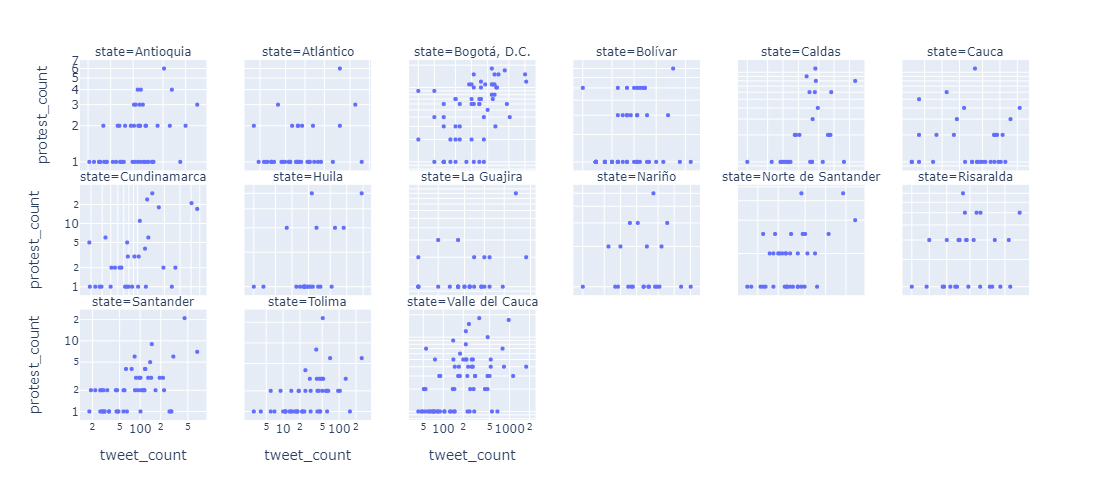

In [16]:
import plotly.express as px
var = "_count"
# var = "s_100k"
fig = px.scatter(state_tp_time[state_tp_time['state'].isin(list(state_tp_time.state.value_counts().index[:15]))], 
                 x=f'tweet{var}', 
                 y=f'protest{var}', 
                 facet_col="state", 
                 facet_col_wrap=6, 
                 log_x=True, 
                 log_y=True,
                 facet_row_spacing=0.04, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 height=500, width=1000)
fig.update_yaxes(matches=None)
fig.update_xaxes(matches=None)
fig.update_traces(marker=dict(size=4))
fig.show()

# ax = sns.scatterplot(data=state_tp_time[state_tp_time['state']=='CA'], x=f'tweet{var}', y=f'protest{var}')
# ax.set(xscale='log', yscale='log')

In [33]:
# state_tp_time[state_tp_time['state']=='OR']

In [352]:
# px.scatter(state_tp_stat_all, x = "count", y="tweets_100k", log_y=True, log_x=True, hover_data=['state', 'tweets_100k', 'count'])

In [351]:
# px.scatter(state_tp_stat_all[state_tp_stat_all['state']!="DC"], x = "count", y="tweets_100k", log_x=True, hover_data=['state', 'tweets_100k', 'count'])

## Time series analysis

### National Level

In [121]:
# policies over time national level
df_leg = df_policies_time_tot[df_policies_time_tot['date_cl'].dt.year>=2020].rename({"date_cl":"date"}, axis=1).set_index("date")
# tweets and protest over national level
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time.csv").drop("Unnamed: 0", axis=1).set_index("date")

df_p_t_leg = pd.merge(df_p_t, df_leg, left_index=True, right_index=True, how="outer")

df_rs = df.groupby('state').resample('D').mean().reset_index().set_index("date")
df_rs['tweet_count'], df_rs['protest_count'] = df_rs['tweet_count'].interpolate(), df_rs['protest_count'].interpolate()
df_p_t_leg = df_p_t_leg.resample('D').mean().reset_index().set_index("date")
df_p_t_leg['tweet_count'], df_p_t_leg['protest_count'], df_p_t_leg['policy_count'] = df_p_t_leg['tweet_count'].interpolate(), df_p_t_leg['protest_count'].interpolate(), df_p_t_leg['policy_count'].interpolate()

In [632]:
df_p_t_leg.reset_index().melt(id_vars="date").to_csv("../data/raw/processed/t_p_leg_time_tidy.csv")

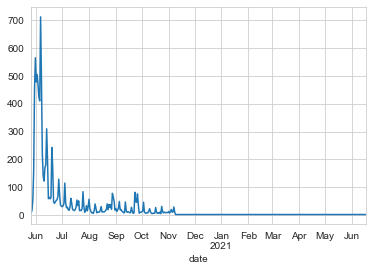

In [434]:
df_p_t_leg['protest_count'].plot()

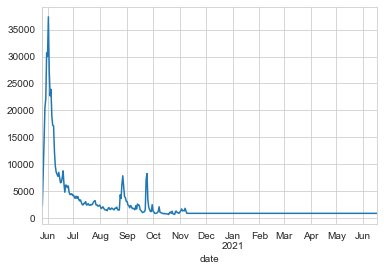

In [435]:
df_p_t_leg['tweet_count'].plot()

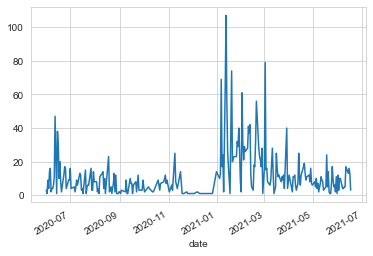

In [168]:
df_p_t_leg['policy_count'].interpolate().dropna().plot()

[None, None]

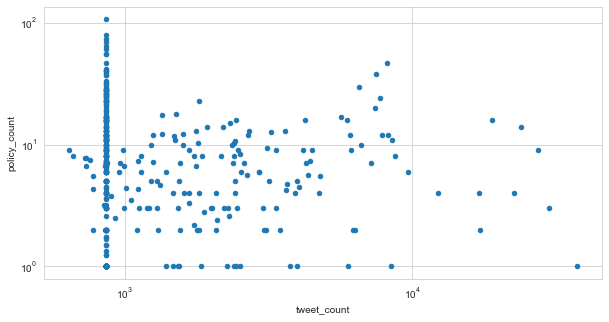

In [436]:
fig, ax = plt.subplots(figsize=(10, 5))
df_p_t_leg.plot(x="tweet_count", y="policy_count", kind="scatter", ax=ax)
ax.set(xscale="log", yscale="log")

#### Time lagged cross corrleation

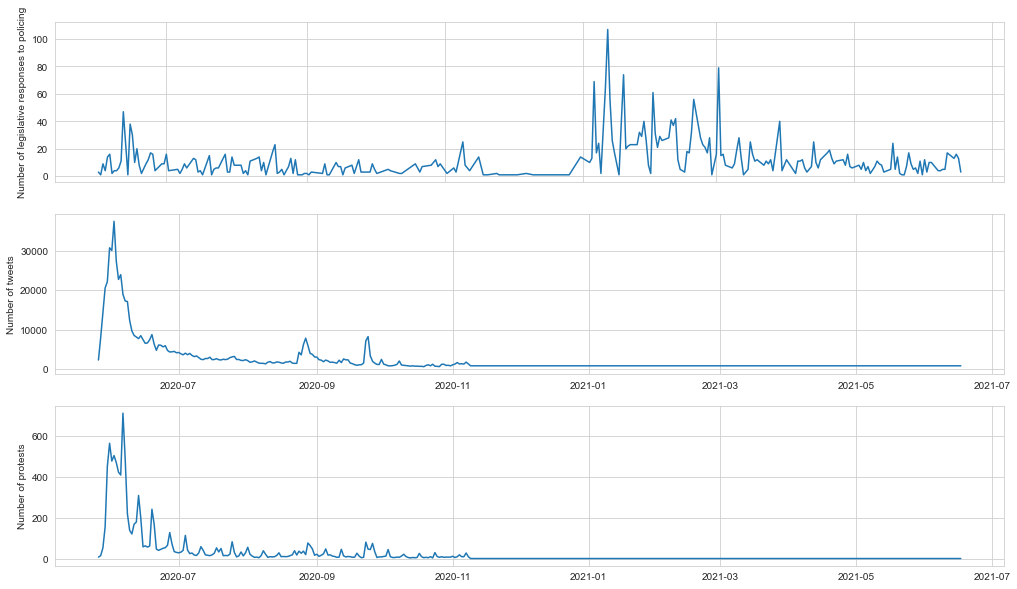

In [633]:
# tweets_geo = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
# sns.set(style ="whitegrid", font_scale=1.5)
# preprocess protest and tweet data
# tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
# tweets_geo['tweet_count'] = 1
# tweets_geo['created_at_day'] = pd.to_datetime(tweets_geo['created_at'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

# df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'], format='%Y-%m-%d')
# df_p_t = pd.merge(tweets_geo[(tweets_geo['created_at_day']>="2020-05-26")&(tweets_geo['created_at_day']<="2020-11-09")].groupby('created_at_day').sum().reset_index().rename(columns={"created_at_day":"date"})[['date', 'tweet_count']],
#          df_p[(df_p['EVENT_DATE']>="2020-05-26")&(df_p['EVENT_DATE']<="2020-11-09")].groupby('EVENT_DATE').sum().reset_index().rename(columns={"EVENT_DATE":"date"})[['date', 'protest_count']])

fig, ax = plt.subplots(3,1, figsize=(17,10))
g1 = sns.lineplot(ax = ax[0], data = df_p_t_leg.interpolate(), x = 'date', y = 'policy_count')#, linewidth = 3)
g1 = sns.lineplot(ax = ax[1], data = df_p_t_leg.interpolate(), x = 'date', y = 'tweet_count')#, linewidth = 3)
g1 = sns.lineplot(ax = ax[2], data = df_p_t_leg.interpolate(), x = 'date', y = 'protest_count')#, linewidth = 3)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[0].set_ylabel("Number of legislative responses to policing")#, fontsize=17)
ax[1].set_ylabel("Number of tweets")#, fontsize=17)
ax[2].set_ylabel("Number of protests")#, fontsize=17)
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)

plt.savefig(f"../reports/figures/6_ts_leg_p_t.PNG", dpi=300)
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Leonardo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide



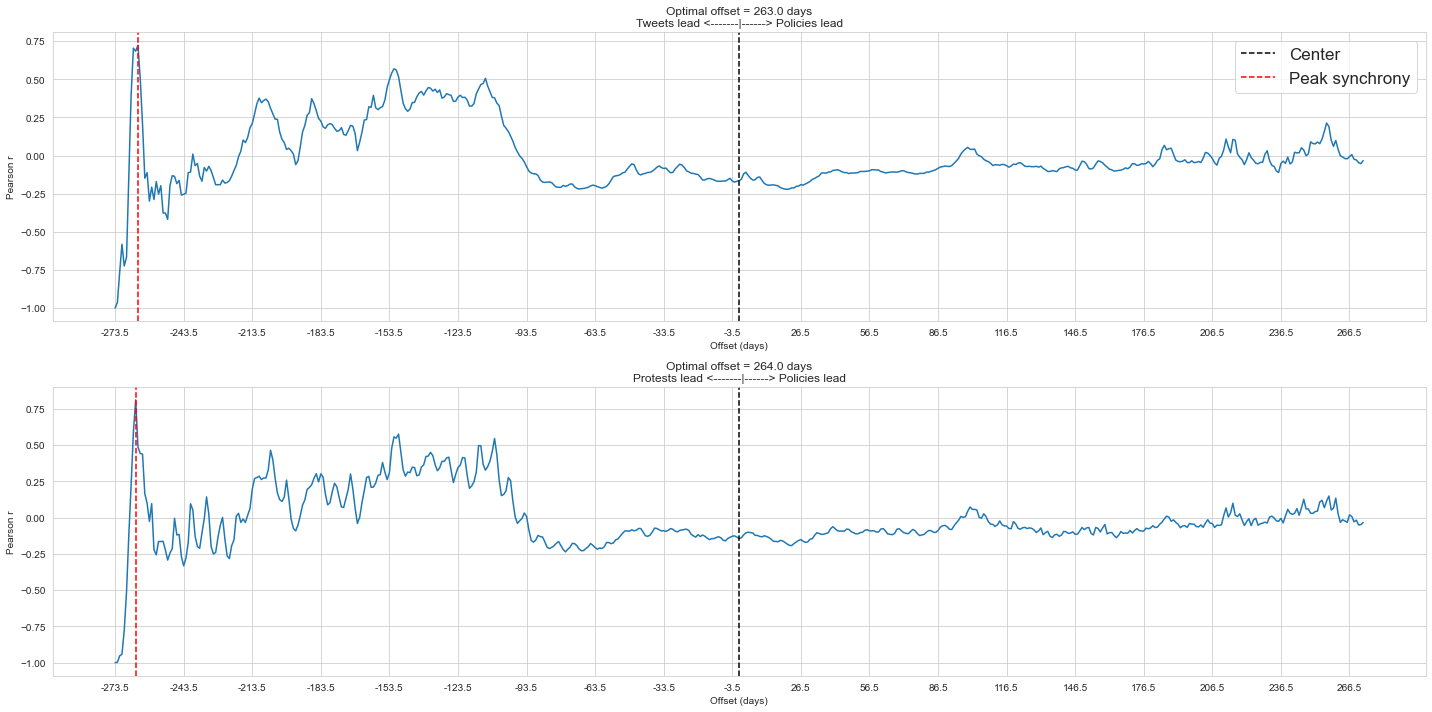

In [647]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy, method ='pearson')
    else: 
        return datax.corr(datay.shift(lag))

# var = "tweet_count"

f, ax = plt.subplots(2, 1, figsize=(20,10))
ax = ax.flatten()
d1 = df_p_t_leg["tweet_count"]
d2 = df_p_t_leg['policy_count']
d3 = df_p_t_leg['protest_count']
days = 400
# tweets
rs = np.array([crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))])
rs = rs[~np.isnan(rs)]
offset = np.floor(len(rs)/2)-np.argmax(rs)
# f,ax=plt.subplots(figsize=(20,5))
ax[0].plot(rs)
ax[0].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
ax[0].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax[0].set(title=f'Optimal offset = {offset} days\nTweets lead <-------|------> Policies lead', xlabel='Offset (days)',ylabel='Pearson r')
ax[0].set_xticks(np.arange(0,len(rs), 30))
ax[0].set_xticklabels(np.arange(-len(rs)/2,(len(rs)/2), 30));
ax[0].legend(fontsize=17)
# protests
rs = np.array([crosscorr(d3,d2, lag) for lag in range(-int(days),int(days+1))])
rs = rs[~np.isnan(rs)]
offset = np.floor(len(rs)/2)-np.argmax(rs)
# f,ax=plt.subplots(figsize=(20,5))
ax[1].plot(rs)
ax[1].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
ax[1].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax[1].set(title=f'Optimal offset = {offset} days\nProtests lead <-------|------> Policies lead', xlabel='Offset (days)',ylabel='Pearson r')
ax[1].set_xticks(np.arange(0,len(rs), 30))
ax[1].set_xticklabels(np.arange(-len(rs)/2,(len(rs)/2), 30));
plt.tight_layout()
# plt.legend()
# plt.savefig(f"../reports/figures/6_tlcc_leg_p_t.PNG", dpi=300)
# plt.savefig("../reports/figures/4_timeLaggedCrossEX.PNG", dpi=300)

In [470]:
np.floor(len(rs)/2)-np.argmax(rs)

9

In [575]:
# rs

In [609]:
lag_t = 236
lag_p = 235
df_p_t_leg['tweet_count_lag'] = df_p_t_leg['tweet_count'].shift(lag_t)
df_p_t_leg['protest_count_lag'] = df_p_t_leg['protest_count'].shift(lag_p)

In [592]:
# df_p_t_leg['tweet_count'].corr(df_p_t_leg['policy_count'].shift(-lag_t), method ='pearson')

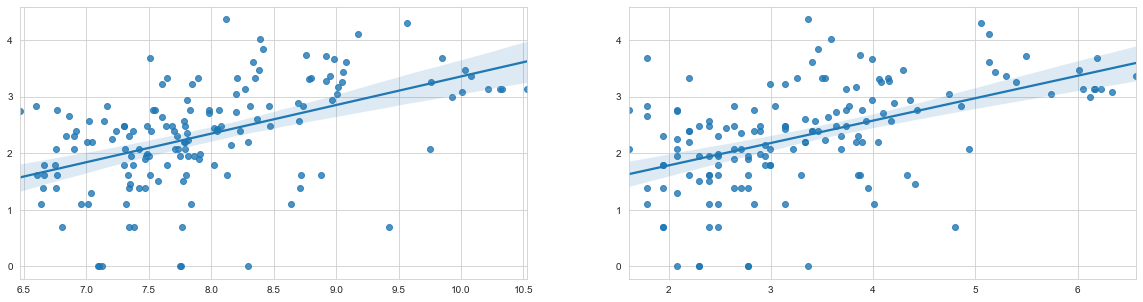

--------------------------------------------------------------------------------------------------------------
Tweets vs. Legislative Responses
Pearson Correlation = 0.494
R^2 score = 0.244
--------------------------------------------------------------------------------------------------------------
Protests vs. Legislative Responses
Pearson Correlation = 0.5
R^2 score = 0.25


In [611]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax = ax.flatten()

X_t = np.log(df_p_t_leg['tweet_count_lag'].interpolate()[lag_t:, None])
X_p = np.log(df_p_t_leg['protest_count_lag'].interpolate()[lag_p:, None])

y = np.log(df_p_t_leg['policy_count'].interpolate()[lag_t:, None])

sns.regplot(x=X_t, y=y, ax=ax[0])
# ax[1].set(xscale="symlog", yscale="symlog")

slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))

y = np.log(df_p_t_leg['policy_count'].interpolate()[lag_p:, None])

sns.regplot(x=X_p, y=y, ax=ax[1])
# ax[0].set(xscale="symlog", yscale="symlog")

slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# ax[0].plot(380, 5.5, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)


plt.show()

print("-"*110)
print("Tweets vs. Legislative Responses")
print(f"Pearson Correlation = {r_value_t.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}")
print("-"*110)
print("Protests vs. Legislative Responses")
print(f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_p**2).round(3)}")

In [607]:
lags = []
r_values = []
r2_values = []
for lag in range(1, 300):
    
# lag = 210
    df_p_t_leg['tweet_count_lag'] = df_p_t_leg['tweet_count'].shift(lag)
    X = np.log(df_p_t_leg['tweet_count_lag'][lag:, None])
    y = np.log(df_p_t_leg['policy_count'][lag:, None])

#     sns.regplot(x=X, y=y, ax=ax)

    slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X[:, None].reshape(-1), y[:, None].reshape(-1))
    lags.append(lag)
    r_values.append(r_value_t)
    r2_values.append(r_value_t**2)
tlcc_t = pd.DataFrame.from_dict({"lag":lags, "pearson_r":r_values, "r2": r2_values}).sort_values("r2", ascending=False)

In [650]:
tlcc_t[tlcc_t["pearson_r"]>0].head(10).to_csv("../data/raw/processed/stat_tests/lr_lags_leg_t.csv")

In [604]:
lags = []
r_values = []
r2_values = []
for lag in range(1, 300):
    
# lag = 210
    df_p_t_leg['protest_count_lag'] = df_p_t_leg['protest_count'].shift(lag)
    X = np.log(df_p_t_leg['protest_count_lag'][lag:, None])
    y = np.log(df_p_t_leg['policy_count'][lag:, None])

#     sns.regplot(x=X, y=y, ax=ax)

    slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X[:, None].reshape(-1), y[:, None].reshape(-1))
    lags.append(lag)
    r_values.append(r_value_t)
    r2_values.append(r_value_t**2)
tlcc_p = pd.DataFrame.from_dict({"lag":lags, "pearson_r":r_values, "r2": r2_values}).sort_values("r2", ascending=False)

In [653]:
tlcc_p[tlcc_p["pearson_r"]>0].head(10)

,lag,pearson_r,r2
234,235,0.499893,0.249893
219,220,0.477622,0.228123
233,234,0.470605,0.221469
220,221,0.458217,0.209963
235,236,0.453669,0.205815
261,262,0.448662,0.201298
227,228,0.447480,0.200238
262,263,0.447346,0.200118
226,227,0.443977,0.197115
241,242,0.435877,0.189989


In [652]:
tlcc_p[tlcc_p["pearson_r"]>0].head(10).to_csv("../data/raw/processed/stat_tests/lr_lags_leg_p.csv")

In [612]:
df_p_t_leg.drop("tweet_count_lag_232", axis=1).to_csv("../data/raw/processed/tweets_protests_leg_time.csv")

In [555]:
# f, ax = plt.subplots(2, 1, figsize=(20,10))
# ax = ax.flatten()
# days = 300
# # tweets
# offset = tlcc_t.lag[tlcc_t.pearson_r == tlcc_t.pearson_r.max()].values[0]
# # f,ax=plt.subplots(figsize=(20,5))
# rs = tlcc_t.pearson_r
# ax[0].plot(rs)
# ax[0].axvline(np.ceil((len(rs))/2), color='k',linestyle='--',label='Center')
# ax[0].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
# ax[0].set(title=f'Optimal offset = {offset} days\nTweets lead <-------|------> Policies lead', xlabel='Offset (days)',ylabel='Pearson r')
# # ax[0].set_xticks(np.arange(0,len(rs), 30))
# # ax[0].set_xticklabels(np.arange(-len(rs)/2,(len(rs)/2)+10, 30));

# # protests
# offset = tlcc_p.lag[tlcc_p.pearson_r == tlcc_p.pearson_r.max()].values[0]
# # f,ax=plt.subplots(figsize=(20,5))
# rs = tlcc_p.pearson_r
# ax[1].plot(rs)
# ax[1].axvline(np.ceil((len(rs))/2), color='k',linestyle='--',label='Center')
# ax[1].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
# ax[1].set(title=f'Optimal offset = {offset} days\nProtests lead <-------|------> Policies lead', xlabel='Offset (days)',ylabel='Pearson r')
# # ax[1].set_xticks(np.arange(0,len(rs), 30))
# # ax[1].set_xticklabels(np.arange(-len(rs)/2,(len(rs)/2)+10, 30));
# plt.tight_layout()
# # plt.legend()
# # plt.savefig(f"../reports/figures/6_tlcc_leg_p_t.PNG", dpi=300)
# # plt.savefig("../reports/figures/4_timeLaggedCrossEX.PNG", dpi=300)

### State Level 

In [174]:
date = "_0622"
# policies over time by state
df_policies_time = pd.read_csv(f"../data/raw/processed/state_policies{date}.csv")
df_policies_time.date_cl = pd.to_datetime(df_policies_time.date_cl)
df_policies_time = df_policies_time[df_policies_time['date_cl'].dt.year>=2020].rename({"date_cl":"date"}, axis=1)#.reset_index()
# # # tweets and protest over time by state
state_tp_time = pd.read_csv("../data/raw/processed/state_tp_time.csv")[["date", "state", 'tweet_count', 'protest_count']]#.set_index("date")
state_tp_time.date = pd.to_datetime(state_tp_time.date)
df_p_t_leg = pd.merge(state_tp_time, df_policies_time, on = ['state', "date"], how="outer")

df_p_t_leg = df_p_t_leg.set_index("date").groupby('state').resample('D').mean().reset_index().set_index("date").drop("Unnamed: 0", axis=1)
df_p_t_leg['tweet_count'], df_p_t_leg['protest_count'], df_p_t_leg['policy_count'] = df_p_t_leg['tweet_count'].interpolate(), df_p_t_leg['protest_count'].interpolate(), df_p_t_leg['policy_count'].interpolate()

In [61]:
# fig, ax = plt.subplots(figsize=(10,5))
# sns.lineplot(data = df_p_t_leg[df_p_t_leg.state=="CA"], x="date", y="policy_count")

In [254]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

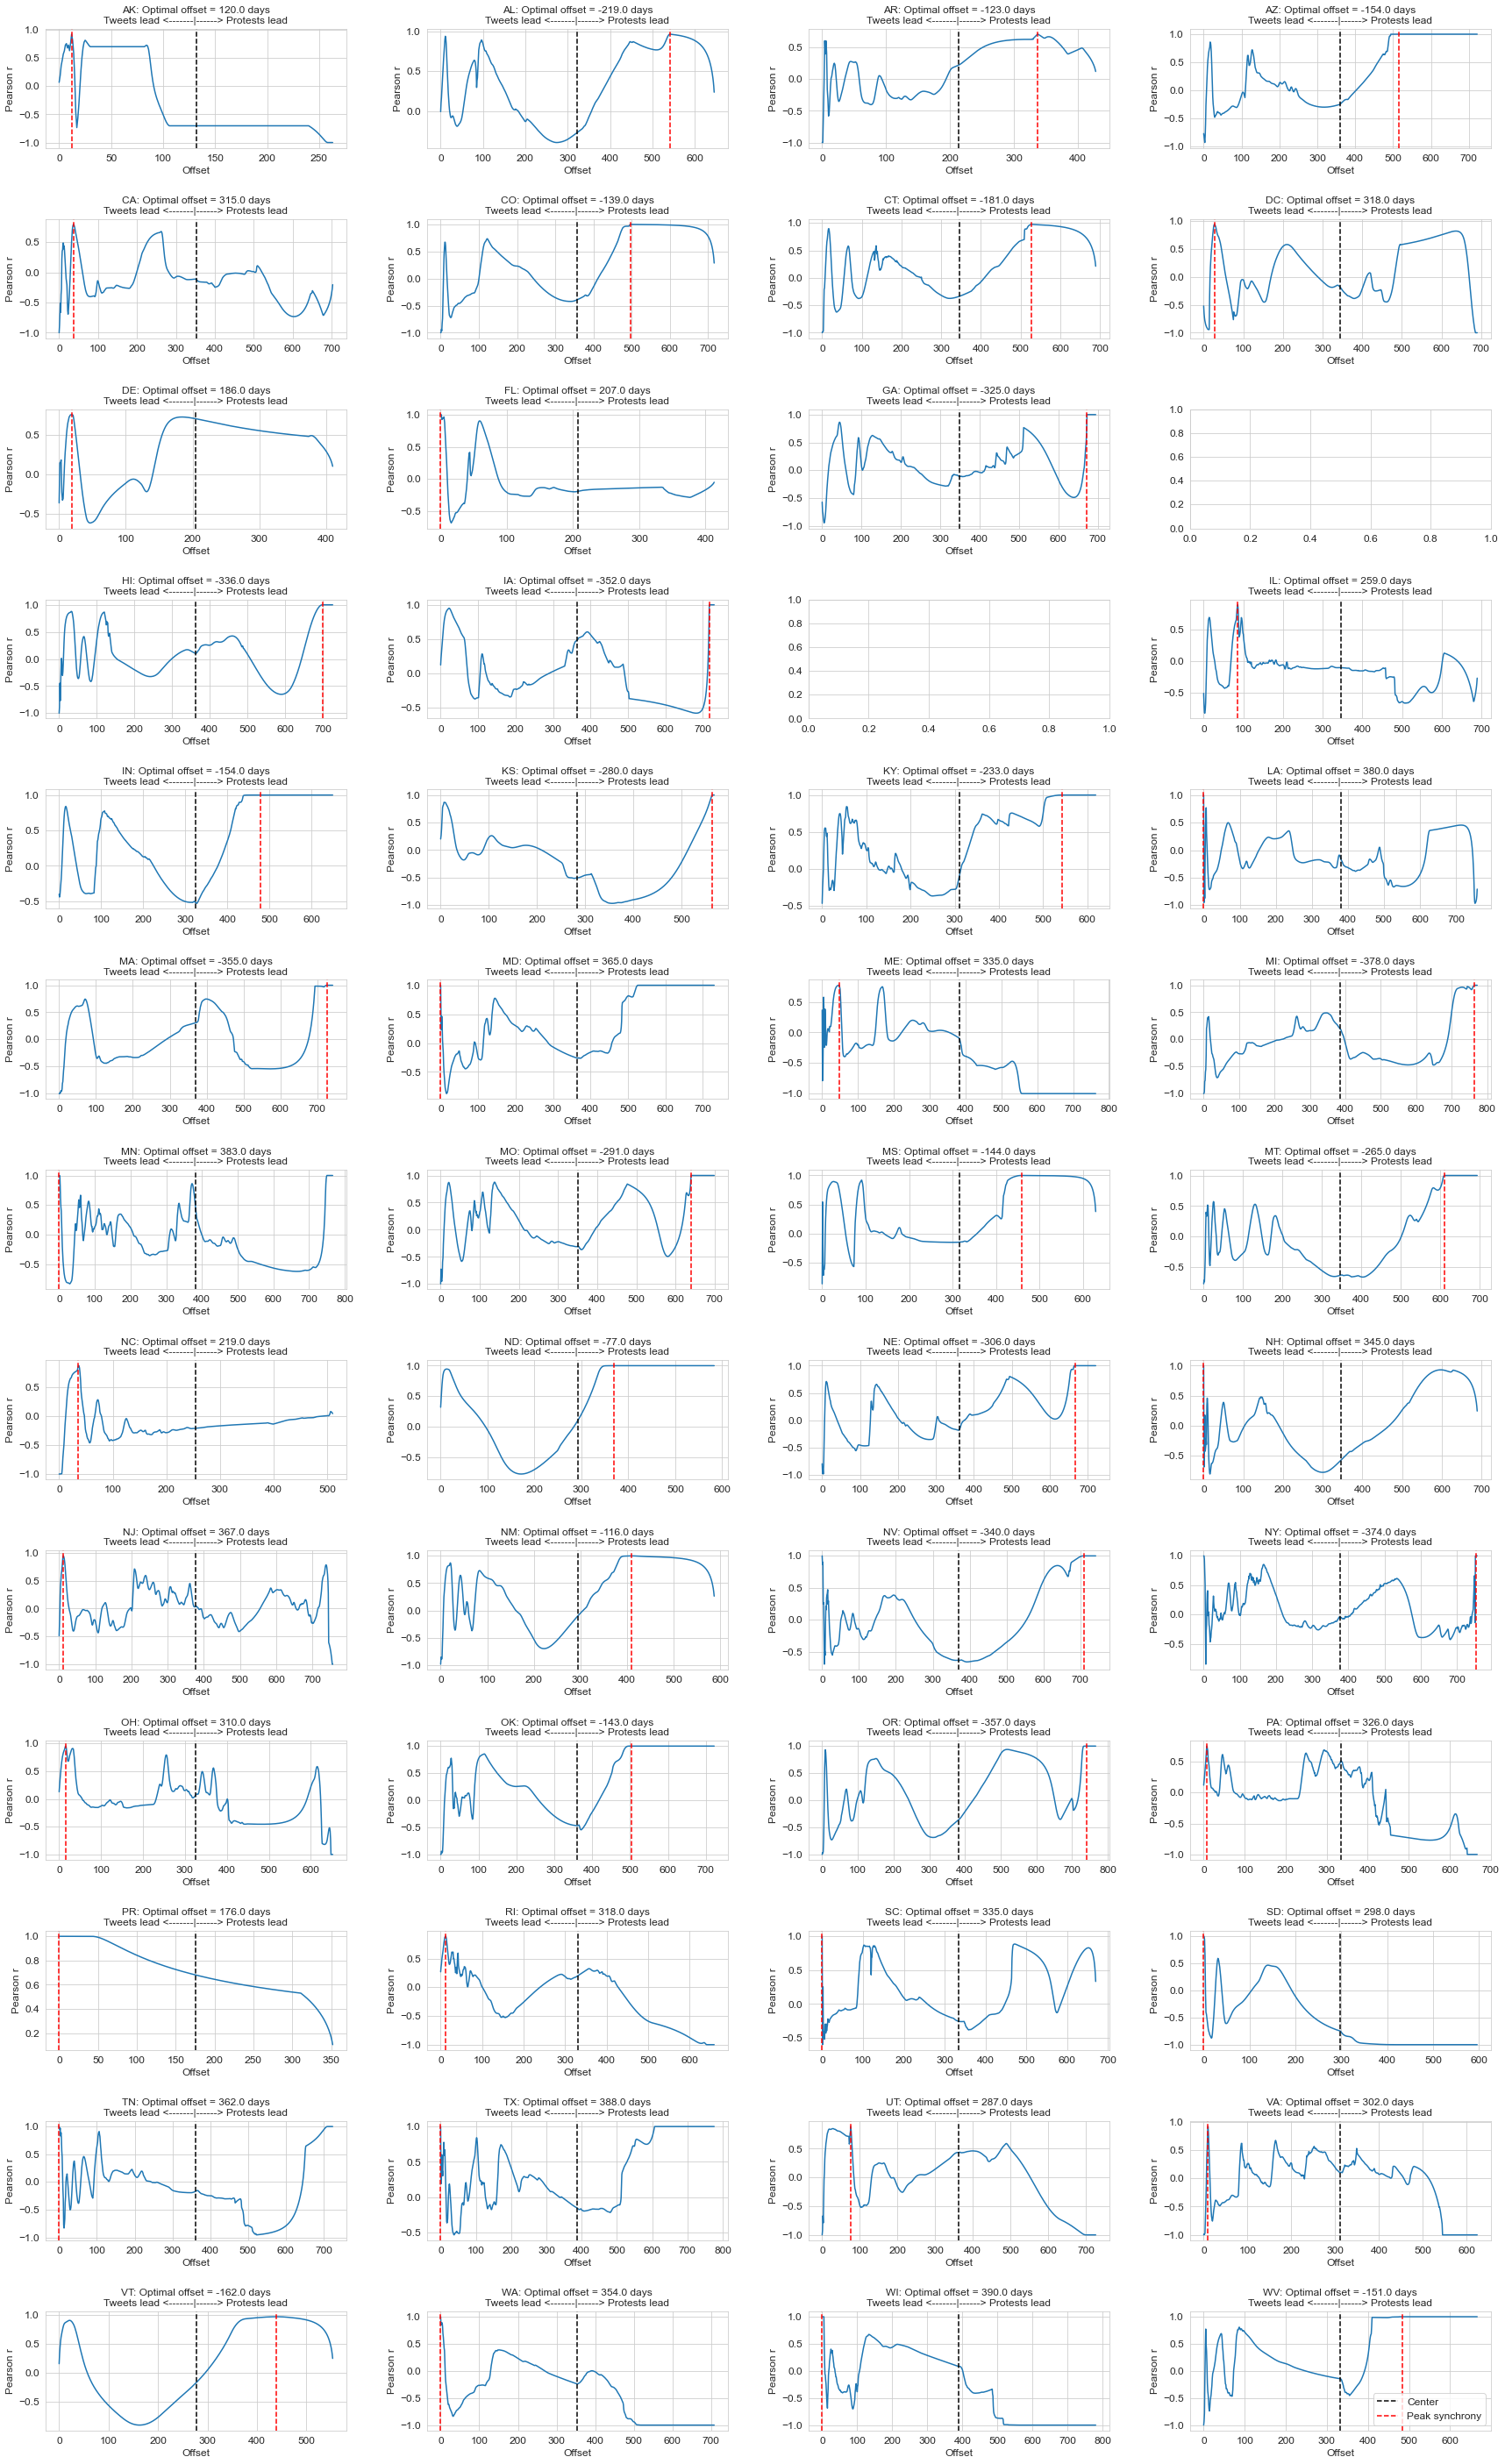

In [255]:
fig, axes = plt.subplots(13, 4, figsize=(25,40))
# fig.suptitle('3 rows x 4 columns axes with no data')
fig.tight_layout(pad=5.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax_num = 0

axes = axes.flatten()

offsets = []
states = []

for state in df_p_t_leg['state'].unique():
    
    data = df_p_t_leg[df_p_t_leg['state']==state]
    d1 = data['tweet_count']
    d2 = data['policy_count']
#     days = 8
#     rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
#     offset = np.floor(len(rs)/2)-np.argmax(rs)
    
    days = 500
    rs = np.array([crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))])
    rs = rs[~np.isnan(rs)]
    
    try:
        offset = np.floor(len(rs)/2)-np.argmax(rs)
        axes[ax_num].plot(rs)
        axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
        axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
        axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead', xlabel='Offset',ylabel='Pearson r')
    #     axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    #     axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
        plt.legend()

        offsets.append(offset)
        states.append(state)
    except (ValueError, IndexError):
        pass
#     f,ax=plt.subplots(figsize=(14,3))
#     axes[ax_num].plot(rs)
#     axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
#     axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#     axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
# #     axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
# #     axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
#     plt.legend()
    
#     offsets.append(offset)
#     states.append(state)
    ax_num +=1
    
plt.savefig("../reports/figures/6_ap_tlcc_tleg_state.png", dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

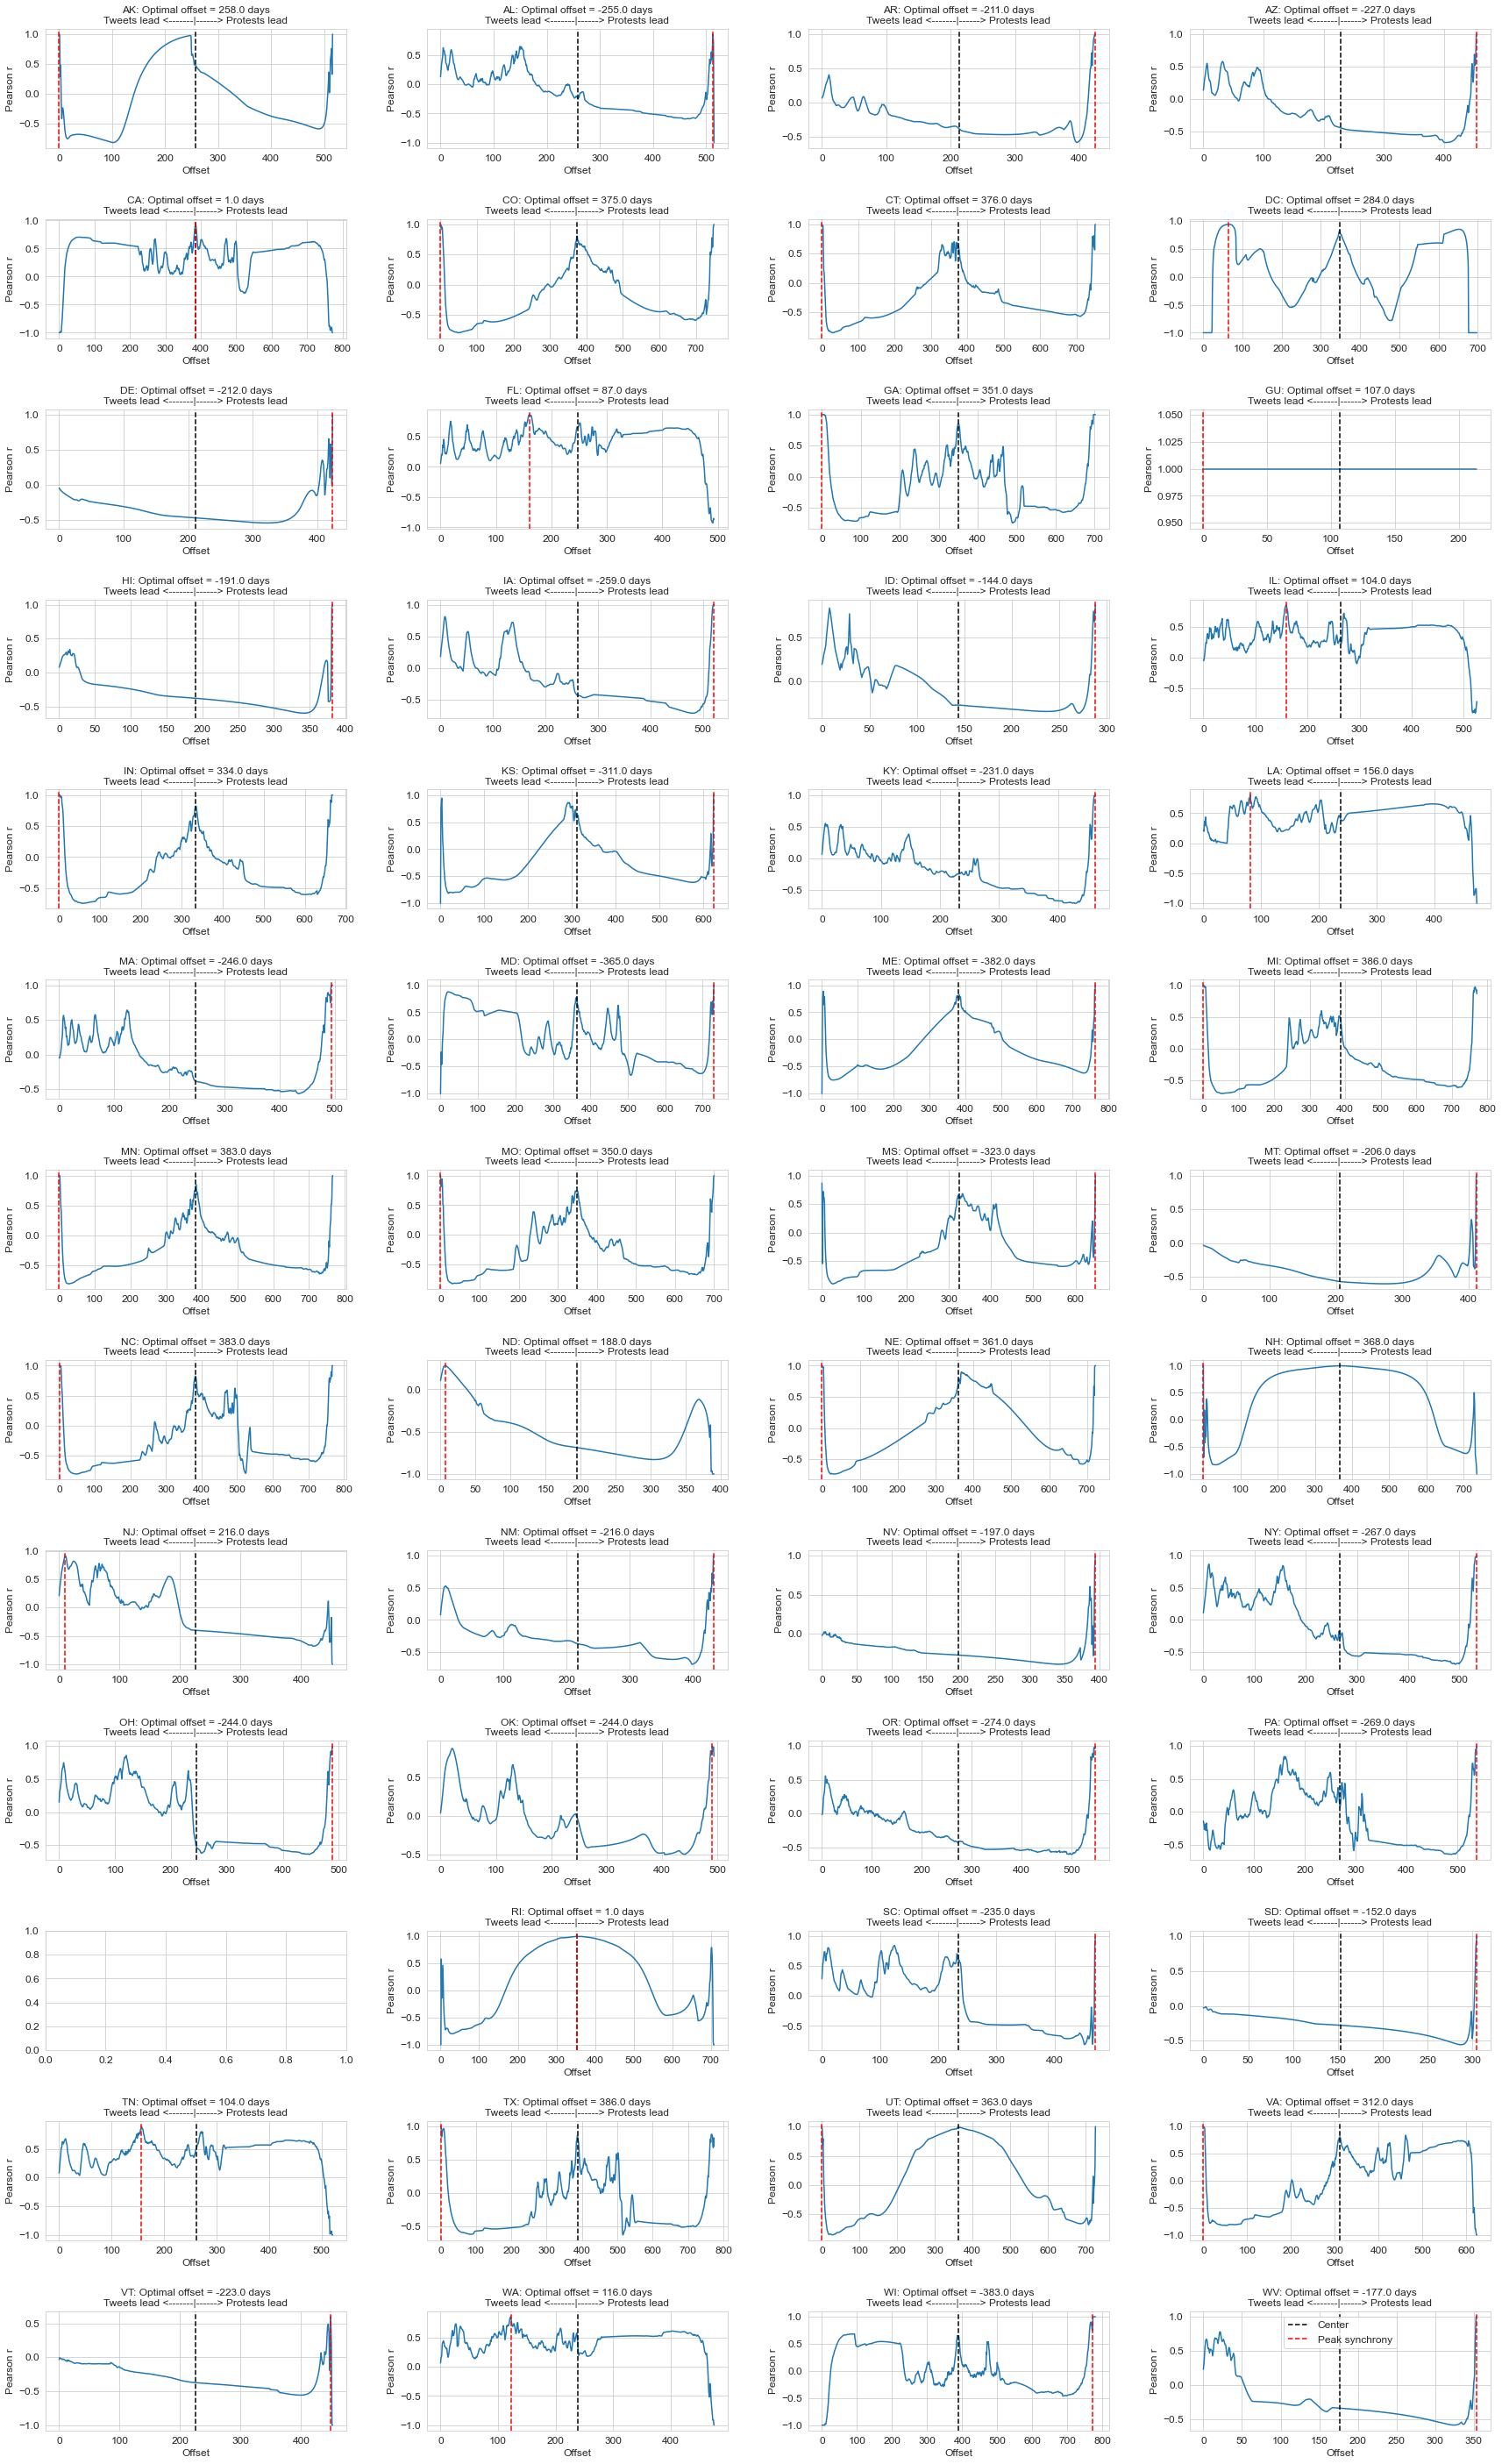

In [256]:
fig, axes = plt.subplots(13, 4, figsize=(25,40))
# fig.suptitle('3 rows x 4 columns axes with no data')
fig.tight_layout(pad=5.0)

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax_num = 0

axes = axes.flatten()

offsets = []
states = []

for state in df_p_t_leg['state'].unique():
    
    data = df_p_t_leg[df_p_t_leg['state']==state]
    d1 = data['tweet_count']
    d2 = data['protest_count']
#     days = 8
#     rs = [crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))]
#     offset = np.floor(len(rs)/2)-np.argmax(rs)
    
    days = 500
    rs = np.array([crosscorr(d1,d2, lag) for lag in range(-int(days),int(days+1))])
    rs = rs[~np.isnan(rs)]
    
    try:
        offset = np.floor(len(rs)/2)-np.argmax(rs)
        axes[ax_num].plot(rs)
        axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
        axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
        axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead', xlabel='Offset',ylabel='Pearson r')
    #     axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    #     axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
        plt.legend()

        offsets.append(offset)
        states.append(state)
    except (ValueError, IndexError):
        pass
#     f,ax=plt.subplots(figsize=(14,3))
#     axes[ax_num].plot(rs)
#     axes[ax_num].axvline(np.ceil((len(rs)-1)/2), color='k',linestyle='--',label='Center')
#     axes[ax_num].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#     axes[ax_num].set(title=f'{state}: Optimal offset = {offset} days\nTweets lead <-------|------> Protests lead',ylim=[0.4,1], xlabel='Offset',ylabel='Pearson r')
# #     axes[ax_num].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
# #     axes[ax_num].set_xticklabels([-8, -6, -4, -2, 0, 2, 4, 6, 8]);
#     plt.legend()
    
#     offsets.append(offset)
#     states.append(state)
    ax_num +=1
    
plt.savefig("../reports/figures/6_ap_tlcc_pleg_state.png", dpi=300)

In [164]:
tlcc_p_dfs = []
for state in df_p_t_leg['state'][~df_p_t_leg.state.isin(["GU", "PR"])].unique():
    
    data = df_p_t_leg[df_p_t_leg['state']==state]
    
    states = []
    lags = []
    r_values = []
    r2_values = []

    for lag in range(1, 260):

    # lag = 210
        data['protest_count_lag'] = data['protest_count'].shift(lag)
        X = np.log(data['protest_count_lag'][lag:, None])
        y = np.log(data['policy_count'][lag:, None])

        slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X[:, None].reshape(-1), y[:, None].reshape(-1))
        lags.append(lag)
        r_values.append(r_value_t)
        r2_values.append(r_value_t**2)
        states.append(state)
        
    tlcc_p = pd.DataFrame.from_dict({"state": states, "lag":lags, "pearson_r":r_values, "r2": r2_values}).sort_values("r2", ascending=False)
    tlcc_p_dfs.append(tlcc_p)
    
tlcc_p_df = pd.concat(tlcc_p_dfs)

In [165]:
tlcc_t_dfs = []
for state in df_p_t_leg['state'][~df_p_t_leg.state.isin(["GU", "PR"])].unique():
    
    data = df_p_t_leg[df_p_t_leg['state']==state]
    
    states = []
    lags = []
    r_values = []
    r2_values = []

    for lag in range(1, 260):

    # lag = 210
        data['tweet_count_lag'] = data['tweet_count'].shift(lag)
        X = np.log(data['tweet_count_lag'][lag:, None])
        y = np.log(data['policy_count'][lag:, None])

        slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X[:, None].reshape(-1), y[:, None].reshape(-1))
        lags.append(lag)
        r_values.append(r_value_t)
        r2_values.append(r_value_t**2)
        states.append(state)
        
    tlcc_p = pd.DataFrame.from_dict({"state": states, "lag":lags, "pearson_r":r_values, "r2": r2_values}).sort_values("r2", ascending=False)
    tlcc_t_dfs.append(tlcc_p)
    
tlcc_t_df = pd.concat(tlcc_t_dfs)

In [166]:
best_lags_p = []
for state in tlcc_p_df['state'].unique():
    best_lag = tlcc_p_df[tlcc_p_df['state']==state].sort_values("pearson_r", ascending=False).head(1)
    best_lags_p.append(best_lag)
    
best_lags_df_p = pd.concat(best_lags_p)

In [167]:
best_lags = []
for state in tlcc_t_df['state'].unique():
    best_lag = tlcc_t_df[tlcc_t_df['state']==state].sort_values("pearson_r", ascending=False).head(1)
    best_lags.append(best_lag)
    
best_lags_df = pd.concat(best_lags)

In [181]:
# best_lags_df

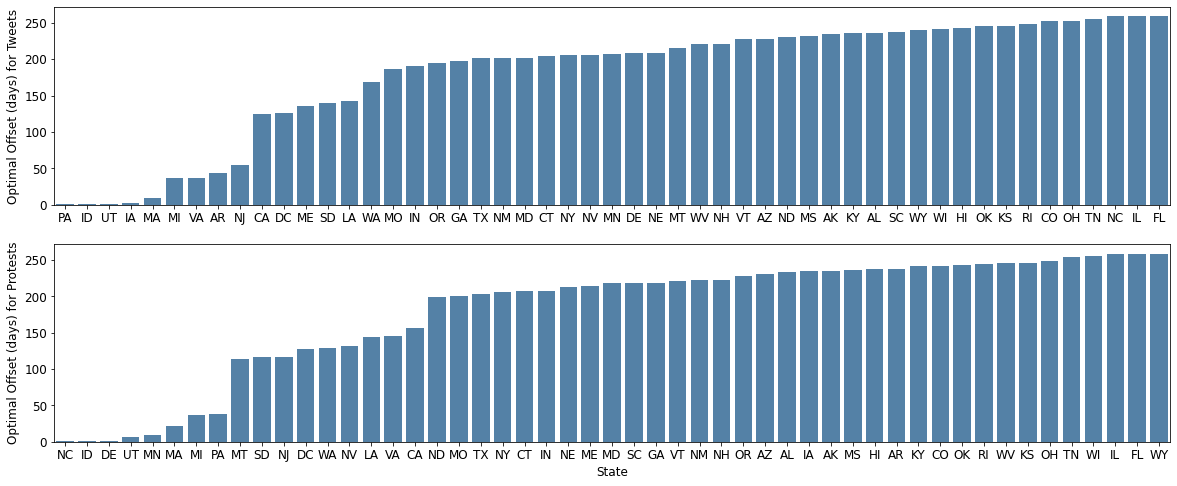

In [198]:
fig, ax = plt.subplots(2, 1, figsize=(20,8))
ax = ax.flatten()
sns.barplot(data = best_lags_df.sort_values("lag"), x="state", y="lag", color = "steelblue", dodge=False, ax=ax[0])
ax[0].set(xlabel="", ylabel="Optimal Offset (days) for Tweets")
sns.barplot(data = best_lags_df_p.sort_values("lag"), x="state", y="lag", color = "steelblue", dodge=False, ax=ax[1])
ax[1].set(xlabel="State", ylabel="Optimal Offset (days) for Protests")
plt.savefig("../reports/figures/6_state_tlcc_leg_stats.png", dpi=300)

# sns.barplot(data = best_lags_df.sort_values("lag"), x="state", y="lag")

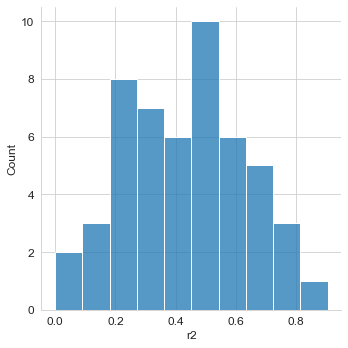

In [261]:
sns.displot(best_lags_df['r2'], bins=10)

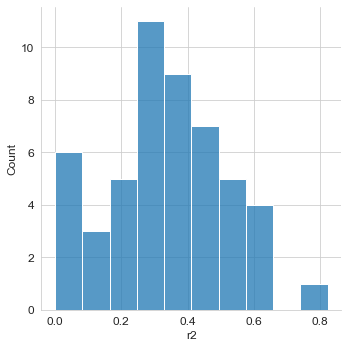

In [262]:
sns.displot(best_lags_df_p['r2'], bins=10)

In [269]:
best_lags_df_p.lag.mean()

179.3921568627451

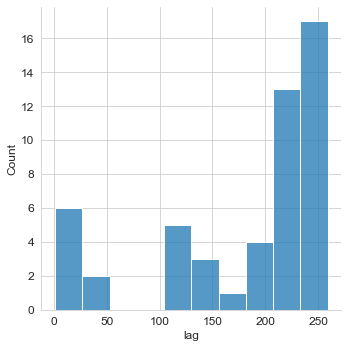

In [265]:
sns.displot(best_lags_df_p['lag'], bins=10)

In [208]:
# tlcc_p_df[tlcc_p_df['state']=="NY"].sort_values("pearson_r", ascending=False)

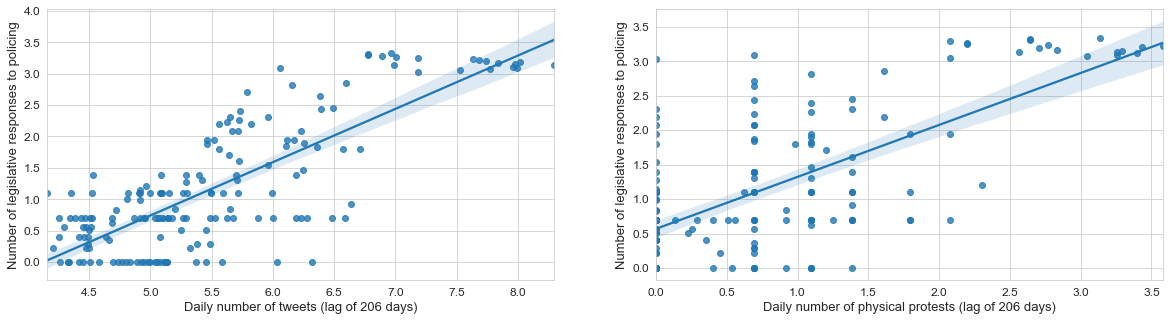

--------------------------------------------------------------------------------------------------------------
Tweets vs. Legislative Responses
Pearson Correlation = 0.79
R^2 score = 0.624
--------------------------------------------------------------------------------------------------------------
Protests vs. Legislative Responses
Pearson Correlation = 0.677
R^2 score = 0.459


In [223]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.set_style("whitegrid")
ax = ax.flatten()

state = "NY"
data = df_p_t_leg[df_p_t_leg['state']==state]

lag_t = best_lags_df[best_lags_df['state']==state].lag.values[0]
lag_p = best_lags_df_p[best_lags_df_p['state']==state].lag.values[0]

data['tweet_count_lag'] = data['tweet_count'].shift(lag_t)
data['protest_count_lag'] = data['protest_count'].shift(lag_p)

X_t = np.log(data['tweet_count_lag'].interpolate()[lag_t:, None])
X_p = np.log(data['protest_count_lag'].interpolate()[lag_p:, None])

y = np.log(data['policy_count'].interpolate()[lag_t:, None])

sns.regplot(x=X_t, y=y, ax=ax[0])
# ax[1].set(xscale="symlog", yscale="symlog")

slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))

y = np.log(data['policy_count'].interpolate()[lag_p:, None])

sns.regplot(x=X_p, y=y, ax=ax[1])
# ax[0].set(xscale="symlog", yscale="symlog")

slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# ax[0].plot(380, 5.5, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)

# text annotations
# plt.suptitle("Hashtag-induced political change", fontsize=18, fontweight='bold')
# plt.title("Tweeting density vs. protest density vs. number of legislative responses", fontsize=18)

ax[0].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[1].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[0].set_xlabel(f"Daily number of tweets (lag of {lag_t} days)", fontsize=13)
ax[1].set_xlabel(f"Daily number of physical protests (lag of {lag_p} days)", fontsize=13)

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Number of legislative responses", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Number of legislative responses", fontsize=14)

plt.savefig(f"../reports/figures/6_{state}_tp_leg_lag.png", dpi=300)
plt.show()

print("-"*110)
print("Tweets vs. Legislative Responses")
print(f"Pearson Correlation = {r_value_t.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}")
print("-"*110)
print("Protests vs. Legislative Responses")
print(f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_p**2).round(3)}")

In [189]:
# tlcc_tp_dfs = []
# for state in df_p_t_leg['state'][~df_p_t_leg.state.isin(["GU", "PR"])].unique():
    
#     data = df_p_t_leg[df_p_t_leg['state']==state]
    
#     states = []
#     lags = []
#     r_values = []
#     r2_values = []

#     for lag in range(0, 12):

#     # lag = 210
#         data['tweet_count_lag'] = data['tweet_count'].shift(lag)
#         X = np.log(data['tweet_count_lag'][lag:, None])
#         y = np.log(data['protest_count'][lag:, None])

#         slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X[:, None].reshape(-1), y[:, None].reshape(-1))
#         lags.append(lag)
#         r_values.append(r_value_t)
#         r2_values.append(r_value_t**2)
#         states.append(state)
        
#     tlcc_p = pd.DataFrame.from_dict({"state": states, "lag":lags, "pearson_r":r_values, "r2": r2_values}).sort_values("r2", ascending=False)
#     tlcc_tp_dfs.append(tlcc_p)
    
# tlcc_tp_df = pd.concat(tlcc_tp_dfs)

In [190]:
# best_lags_tp = []
# for state in tlcc_tp_df['state'].unique():
#     best_lag = tlcc_tp_df[tlcc_tp_df['state']==state].sort_values("pearson_r", ascending=False).head(1)
#     best_lags_tp.append(best_lag)
    
# best_lags_df_tp = pd.concat(best_lags_tp)

In [193]:
# fig, ax = plt.subplots(figsize=(20,5))
# sns.barplot(data = best_lags_df_tp.sort_values("lag"), x="state", y="lag", color = "steelblue", dodge=False)
# ax.set(xlabel="State", ylabel="Optimal Offset (days)")

In [276]:
### Granger causality
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1

test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_p_t_leg[["protest_count", "policy_count"]], variables = ["policy_count", "tweet_count"]) 

In [275]:
df_p_t_leg

,state,tweet_count,protest_count,policy_count
date,,,,
2020-05-29,AK,24.0,1.0,NaN
2020-05-30,AK,33.0,4.0,NaN
2020-05-31,AK,46.0,2.0,NaN
2020-06-01,AK,27.0,6.0,NaN
2020-06-02,AK,41.0,4.0,NaN
...,...,...,...,...
2021-04-17,WY,4.0,1.0,1.0
2021-04-18,WY,4.0,1.0,1.0
2021-04-19,WY,4.0,1.0,1.0


## Simple regression analysis (no generalization)

### tweets vs. legislature and protests vs. legislature

index measuring for each day distance between place with highest concentration of tweets and place with highest concentration of protests
make multiple regression plots:
- tweet at time t vs protest a time t+1, same with t+2, same with t+3... SPATIALLY
- plot networks in space: maybe tweets spatially close together are part of the same highly connected subgraph --> would explain the spatial relation

In [1023]:
# fig = sns.regplot(data = state_tp_stat_all, x = "tweets_100k", y = "per_dem_2020", scatter_kws={"s": 60}, ci=None)
# fig.set_xscale("log")

In [81]:
state_tp_stat_all.to_csv(f"../data/raw/processed/state_tpv_policies{date}.csv")

In [1030]:
# state_tp_stat_all[['state', 'tweets_100k', 'protests_100k', 'count', "2016_2020_turnout_change"]].sort_values("tweets_100k")

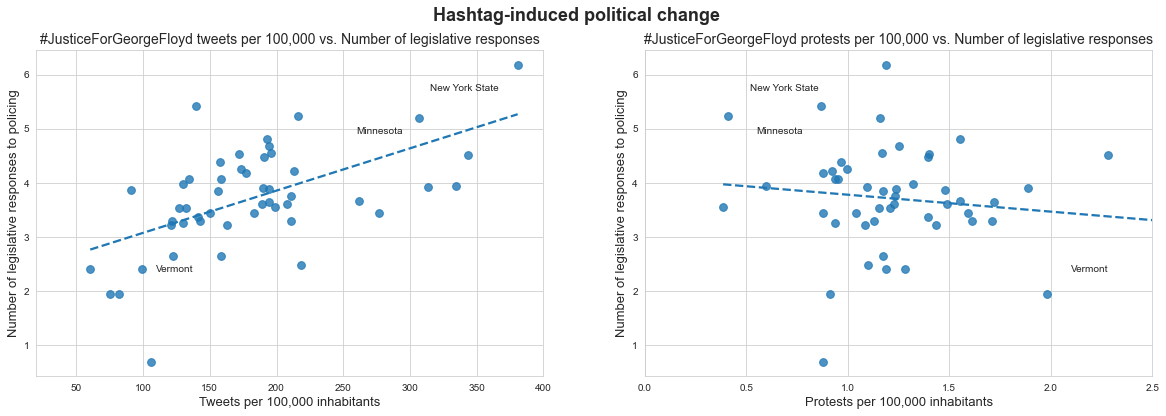

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.567                                                              Pearson Correlation = -0.134
R^2 score = 0.322                                                                        R^2 score = 0.018


In [86]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,6))

df = state_tp_stat_all[~state_tp_stat_all['state'].isin(["USA", "DC"])][['state', 'tweets_100k', 'protests_100k', 'count', "2016_2020_turnout_change"]] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'][:, None])
X_t = df.tweets_100k
X_p = np.log(df.protests_100k)


sns.regplot(ax = ax[0], data = df, x = X_t, y = y, scatter_kws={"s": 60}, ci=None)
sns.regplot(ax = ax[1], data = df, x = X_p, y = y, scatter_kws={"s": 60}, ci=None)
ax[0].lines[0].set_linestyle("--")
ax[1].lines[0].set_linestyle("--")
ax[0].set(xlim=(20, 400))
ax[1].set(xlim=(0, 2.5))
# text annotations
plt.suptitle("Hashtag-induced political change", fontsize=18, fontweight='bold')
# plt.title("Tweeting density vs. protest density vs. number of legislative responses", fontsize=18)

ax[0].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[1].set_ylabel("Number of legislative responses to policing", fontsize=13)
ax[0].set_xlabel("Tweets per 100,000 inhabitants", fontsize=13)
ax[1].set_xlabel("Protests per 100,000 inhabitants", fontsize=13)

ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Number of legislative responses", fontsize=14)
ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Number of legislative responses", fontsize=14)


# regression scores
slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))
slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# ax[0].plot(380, 5.5, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)

ax[0].annotate(f"New York State", xy=(315, 5.7), xytext=(315, 5.7))
ax[1].annotate(f"New York State", xy=(0.52, 5.7), xytext=(0.52, 5.7))
ax[0].annotate(f"Minnesota", xy=(260, 4.9), xytext=(260, 4.9))
ax[1].annotate(f"Minnesota", xy=(0.55, 4.9), xytext=(0.55, 4.9))
ax[0].annotate(f"Vermont", xy=(110, 2.35), xytext=(110, 2.35))
ax[1].annotate(f"Vermont", xy=(2.1, 2.35), xytext=(2.1, 2.35))

plt.show()
print("-"*110)
print(f"Pearson Correlation = {r_value_t.round(3)}", " "*60, f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}", " "*70, f"R^2 score = {(r_value_p**2).round(3)}")

In [90]:
import statsmodels.api as sm

y = sm.add_constant(y, prepend=False)
mod = sm.OLS(X_t, y)
res = mod.fit()
print(res.summary())

y = sm.add_constant(y, prepend=False)
mod = sm.OLS(X_p, y)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            tweets_100k   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     22.08
Date:                Sun, 23 May 2021   Prob (F-statistic):           2.31e-05
Time:                        23:59:00   Log-Likelihood:                -267.62
No. Observations:                  49   AIC:                             539.2
Df Residuals:                      47   BIC:                             543.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            39.6263      8.433      4.699      0.0

### tweets vs. turnout and protests vs. turnout

In [698]:
# state_tp_stat_all

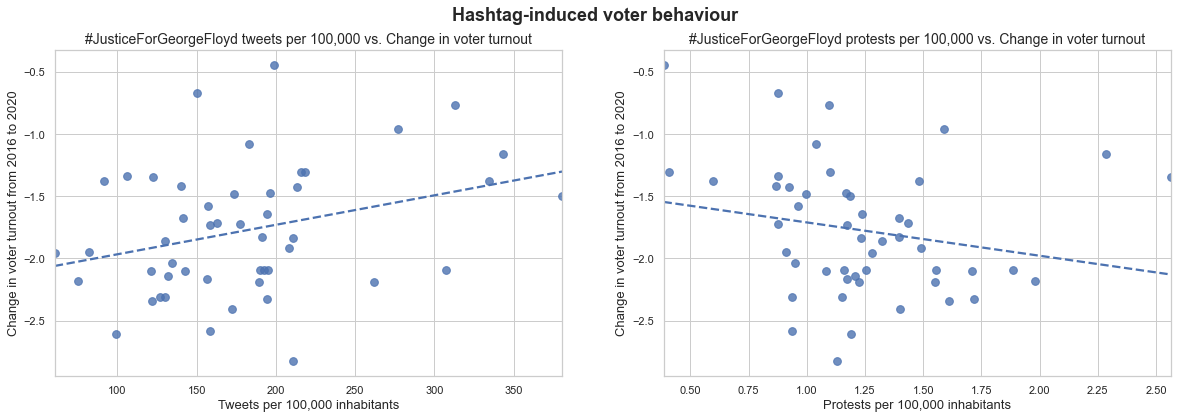

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.32                                                              Pearson Correlation = -0.212
R^2 score = 0.102                                                                        R^2 score = 0.045


In [91]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import scipy
sns.set(style ="whitegrid", font_scale=1)

fig, ax = plt.subplots(1, 2, figsize=(20,6))

df = state_tp_stat_all[state_tp_stat_all['state']!="DC"][['tweets_100k', 'protests_100k', '2016_2020_turnout_change']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['2016_2020_turnout_change'][:, None])
X_t = df.tweets_100k
X_p = np.log(df.protests_100k)


sns.regplot(ax = ax[0], data = df, x = X_t, y = y, scatter_kws={"s": 60}, ci=None)
sns.regplot(ax = ax[1], data = df, x = X_p, y = y, scatter_kws={"s": 60}, ci=None)
ax[0].lines[0].set_linestyle("--")
ax[1].lines[0].set_linestyle("--")
# ax[0].set(xlim=(20, 400), ylim=(0,))
# ax[1].set(xlim=(0, 2.5), ylim=(0,))
# ax[0].set(xlim=(20, 400))
# ax[1].set(xlim=(0, 2.5))
# text annotations
plt.suptitle("Hashtag-induced voter behaviour", fontsize=18, fontweight='bold')
# plt.title("Tweeting density vs. protest density vs. number of legislative responses", fontsize=18)

ax[0].set_ylabel("Change in voter turnout from 2016 to 2020", fontsize=13)
ax[1].set_ylabel("Change in voter turnout from 2016 to 2020", fontsize=13)
ax[0].set_xlabel("Tweets per 100,000 inhabitants", fontsize=13)
ax[1].set_xlabel("Protests per 100,000 inhabitants", fontsize=13)

ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

# legend
# ax[0].plot(-1, 100, 'o',
#         ms=8, mec='k', color="k", alpha=0.5)

# ax[0].annotate(f" = 1 day", xy=(-0.95, 96), xytext=(-0.95, 96))

# regression scores
slope_t, inercept_t, r_value_t, p_value_t, std_err_t = scipy.stats.linregress(X_t[:, None].reshape(-1), y[:, None].reshape(-1))
slope_p, inercept_p, r_value_p, p_value_p, std_err_p = scipy.stats.linregress(X_p[:, None].reshape(-1), y[:, None].reshape(-1))

# annotations
# style = dict(size=10, color='gray')
# ax[0].text(1, 350, f"R^2 score = {r_value_t**2}", **style)
# ax[1].text(1, 350, f"R^2 score={r_value_p**2}", **style)
plt.show()
print("-"*110)
print(f"Pearson Correlation = {r_value_t.round(3)}", " "*60, f"Pearson Correlation = {r_value_p.round(3)}")
print(f"R^2 score = {(r_value_t**2).round(3)}", " "*70, f"R^2 score = {(r_value_p**2).round(3)}")

## ML regression analysis (model generalization)

#### Tweets vs Policy Count

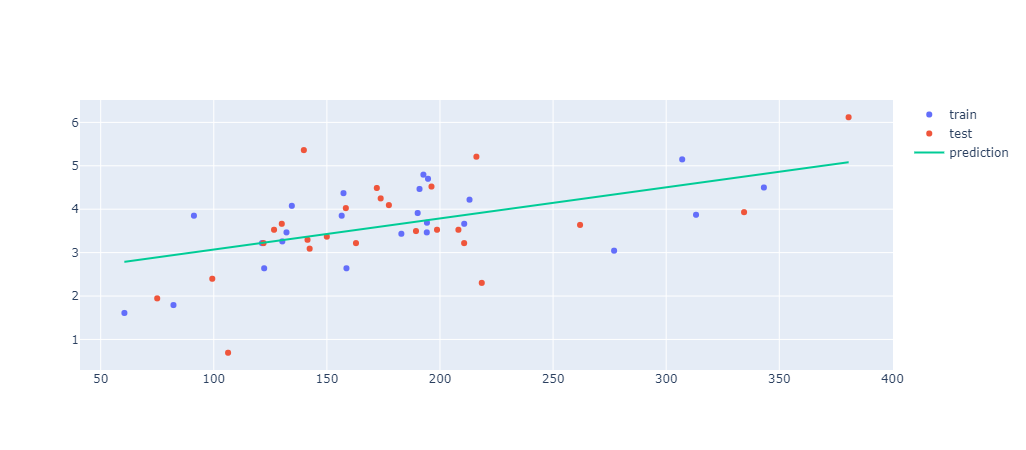

intercept: 2.35
slope: 0.01
MSE: 0.84
RMSE: 0.92
R2:	 0.296


In [42]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

df = state_tp_stat_all[state_tp_stat_all['state']!="DC"][['tweets_100k', 'count']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'])
# y = np.log(df.tweets_100k)

# X = df['count'][:, None]
X = df[['tweets_100k']]

# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range).reshape(-1)


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range.reshape(-1), y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [43]:
# cross validation
folds = KFold(n_splits = 2, shuffle = True, random_state = 0)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.309


#### Protests vs Policy Count

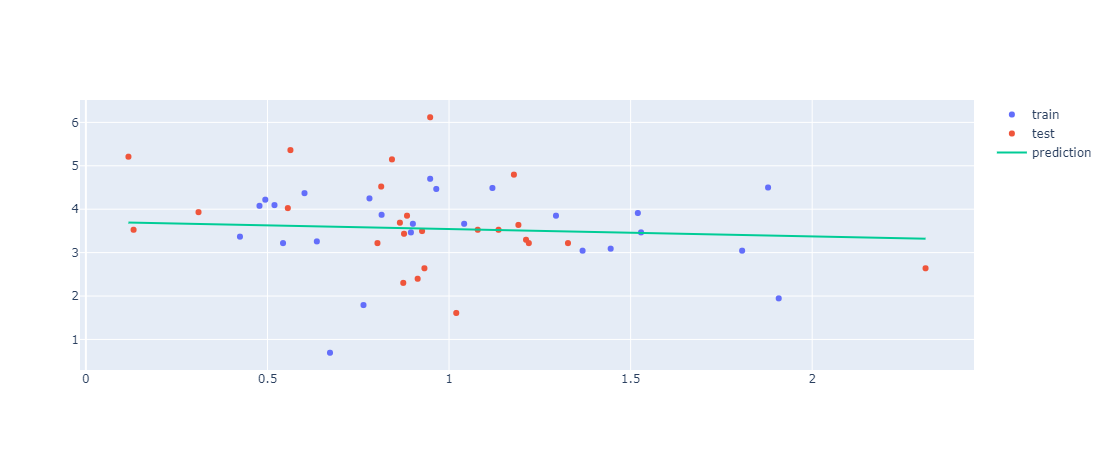

intercept: 3.71
slope: -0.17
MSE: 1.03
RMSE: 1.01
R2:	 0.027


In [44]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
import numpy as np

df = state_tp_stat_all[['protests_100k', 'count']] #[state_tp_stat_all['state']!="DC"]
y = np.log(df['count'][:, None]).reshape(-1)
X = np.log(df.protests_100k[:, None])

# X = df['count'][:, None]
# y = df.protests_100k
# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
# model.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test.reshape(-1, 1))

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [45]:
# cross validation
folds = KFold(n_splits = 2, shuffle = True, random_state = 100)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.017


### Time Series

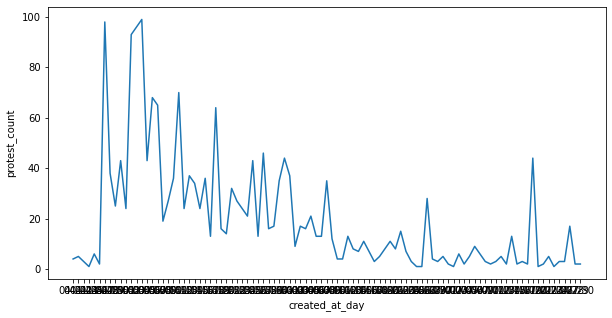

In [25]:
df_p['created_at'] = pd.to_datetime(df_p['EVENT_DATE'])
df_p['protest_count'] = 1
df_p['created_at_day'] = df_p['created_at'].dt.strftime('%m-%d')

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = df_p.groupby('created_at_day').sum().reset_index(), x = 'created_at_day', y = 'protest_count')

In [81]:
# tweets_geo

[Text(0.5, 0, '')]

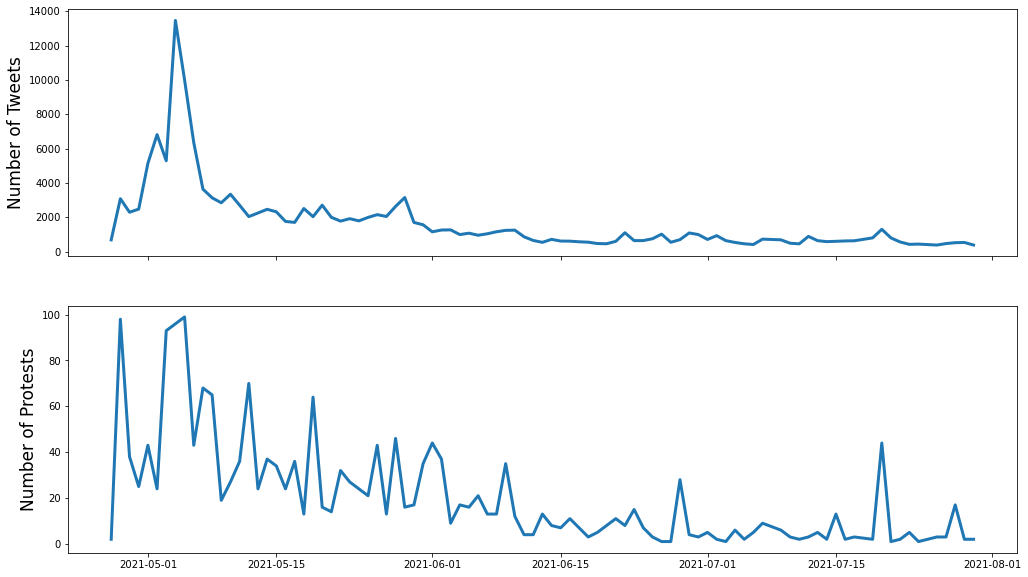

In [27]:
# tweets_geo = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
# sns.set(style ="whitegrid", font_scale=1.5)
# # preprocess protest and tweet data
# tweets_geo['created_at'] = pd.to_datetime(tweets_geo['created_at'])
# tweets_geo['tweet_count'] = 1
# tweets_geo['created_at_day'] = pd.to_datetime(tweets_geo['created_at'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')

df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'], format='%Y-%m-%d')
tweets_geo.created_at_day = pd.to_datetime("2021-"+tweets_geo['created_at_day'])

df_p_t = pd.merge(tweets_geo.groupby('created_at_day').sum().reset_index().rename(columns={"created_at_day":"date"})[['date', 'tweet_count']],
         df_p.groupby('EVENT_DATE').sum().reset_index().rename(columns={"EVENT_DATE":"date"})[['date', 'protest_count']])

fig, ax = plt.subplots(2,1, figsize=(17,10))
g1 = sns.lineplot(ax = ax[0], data = df_p_t, x = 'date', y = 'tweet_count', linewidth = 3)
g2 = sns.lineplot(ax = ax[1], data = df_p_t, x = 'date', y = 'protest_count', linewidth = 3)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylabel("Number of Tweets", fontsize=17)
ax[1].set_ylabel("Number of Protests", fontsize=17)
ax[0].set(xticklabels=[])
ax[0].set(xlabel=None)
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

# ax[0].set_title("#JusticeForGeorgeFloyd tweets per 100,000 vs. Change in voter turnout", fontsize=14)
# ax[1].set_title("#JusticeForGeorgeFloyd protests per 100,000 vs. Change in voter turnout", fontsize=14)

In [88]:
df_p_t.to_csv(f"../data/raw/processed/tweets_protests_time_{country}.csv")

In [13]:
df_p_t = pd.read_csv("../data/raw/processed/tweets_protests_time.csv")

In [98]:
# df_p_t

In [28]:
for lag in range(1, 8):  
    df_p_t[f'protest_count_lag{lag}'] = df_p_t['protest_count'].shift(+lag)
    df_p_t[f'tweet_count_lag{lag}'] = df_p_t['tweet_count'].shift(+lag)

In [29]:
df_p_t.to_csv(f"../data/raw/processed/tweets_protests_time_lag_{country}.csv")

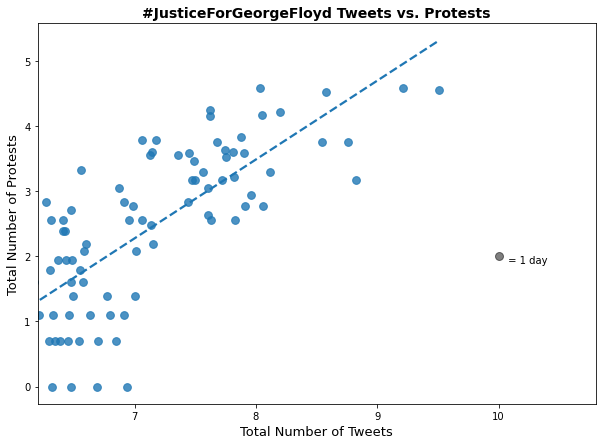

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.764
R^2 score = 0.584


In [30]:
fig, ax = plt.subplots(figsize=(10,7))

X = np.log(df_p_t['tweet_count'][:, None])
y = np.log(df_p_t['protest_count'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(data = df_p_t, x = X, y = y, scatter_kws={"s": 60}, ci=False)
# ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

ax.set(xlim=(6.2, 10.8))
# ax.set_xlim(2000,)

# ax.set_xlim(auto=True)

ax.lines[0].set_linestyle("--")

ax.set_xlabel("Total Number of Tweets", fontsize=13)
ax.set_ylabel("Total Number of Protests", fontsize=13)
ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

# regression metrics
slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

# annotations
style = dict(size=11)
# ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
# ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

# legend
ax.plot(10, 2, 'o',
        ms=8, mec='k', color="k", alpha=0.5)

ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


plt.show()

print("-"*110)
print(f"Pearson Correlation = {r_value.round(3)}")
print(f"R^2 score = {(r_value**2).round(3)}")

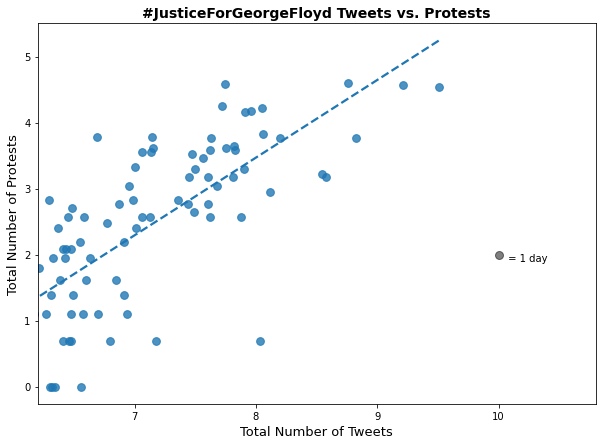

--------------------------------------------------------------------------------------------------------------
Pearson Correlation = 0.748
R^2 score = 0.559


In [48]:
fig, ax = plt.subplots(figsize=(10,7))

lag = 1
ind_var = ["tweet_count", "Tweets"] #ind_var
obs_var = ["protest_count", "Protests"] #obs_var

X = np.log(df_p_t[lag:][ind_var[0]][:, None])
y = np.log(df_p_t[lag:][f'{obs_var[0]}_lag{lag}'][:, None])

# ax.set_yscale("log")
# ax.set_xscale("log")
ax = sns.regplot(data = df_p_t, x = X, y = y, scatter_kws={"s": 60}, ci=False)
# ax = sns.regplot(data = df_p_t, x = 'tweet_count', y = 'protest_count', scatter_kws={"s": 60}, ci=False)

ax.set(xlim=(6.2, 10.8))
# ax.set_xlim(2000,)

# ax.set_xlim(auto=True)

ax.lines[0].set_linestyle("--")

ax.set_xlabel(f"Total Number of {ind_var[1]}", fontsize=13)
ax.set_ylabel(f"Total Number of {obs_var[1]}", fontsize=13)
ax.set_title("#JusticeForGeorgeFloyd Tweets vs. Protests", fontsize=14, fontweight="bold")

# regression metrics
slope, inercept, r_value, p_value, std_err = scipy.stats.linregress(X.reshape(-1), y[:, None].reshape(-1))

# annotations
style = dict(size=11)
# ax.annotate(f"Pearson Correlation = {r_value.round(3)}", xy=(6.5, 6), xytext=(6.5, 6), **style)
# ax.annotate(f"r2 = {(r_value**2).round(3)}", xy=(6.5, 5.7), xytext=(6.5, 5.7), **style)

# legend
ax.plot(10, 2, 'o',
        ms=8, mec='k', color="k", alpha=0.5)

ax.annotate(f" = 1 day", xy=(10.05, 1.9), xytext=(10.05, 1.9))


plt.show()

print("-"*110)
print(f"Pearson Correlation = {r_value.round(3)}")
print(f"R^2 score = {(r_value**2).round(3)}")

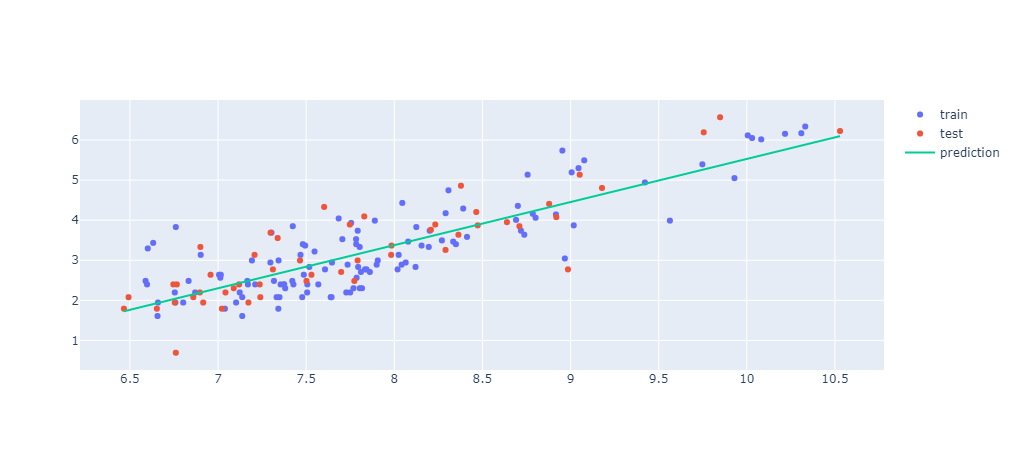

intercept: -5.23
slope: 1.08
MSE: 0.36
RMSE: 0.6
R2:	 0.757


In [164]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

df = df_p_t #[state_tp_stat_all['state']!="DC"]
X = np.log(df_p_t['tweet_count'][:, None])
y = np.log(df_p_t['protest_count'])

# X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='prediction')
])

fig.show()

print("intercept:", model.intercept_.round(2))
print("slope:", model.coef_[0].round(2))

y_pred = model.predict(X_test.reshape(-1, 1))

MSE = mean_squared_error(y_test, y_pred)
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

R2 = r2_score(y_test, y_pred)
print("R2:\t", R2.round(3))

In [165]:
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=folds)

print("The average r2 score with cross validation (k=4) is", scores.mean().round(3))

The average r2 score with cross validation (k=4) is 0.715


In [597]:
# sns.set()

# fig, ax = plt.subplots(figsize=(10, 8))

# data = df_p_t

# sns.regplot(x=np.log10(data['tweet_count']), y=np.log10(data['protest_count']),
#             scatter_kws={'s': 80, 'alpha': 0.5}, ax=ax)

# ax.set_ylabel('Platform1', labelpad=15, fontsize=15)
# ax.set_xlabel('Platform2', labelpad=15, fontsize=15)
# ax.set_title('Sales of the same game in different platforms', pad=30, size=20)

# xticks = ndata['tweet_count'].sample(5))
# yticks = np.log10(data['protest_count'].sample(5))

# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# formatter = lambda x, pos: f'{10 ** x:g}'
# ax.get_xaxis().set_major_formatter(formatter)
# ax.get_yaxis().set_major_formatter(formatter)
# lims = np.log10(np.array([0.005, 25.]))
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# plt.show()

In [504]:
# px.scatter(state_tp_stat_pass[state_tp_stat_pass['state']!="DC"], x = "count", y="tweets_100k", log_x=True, hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019")

In [505]:
# px.scatter(state_tp_stat_fail, x = "count", y="tweets_100k", hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019", log_x=True)

In [506]:
# px.scatter(state_tp_stat_out[(state_tp_stat_out['state']!="DC")&(state_tp_stat_out['tot_outcome']>1)], x = "policy_success_rate", y="tweets_100k", hover_data=['state', 'tweets_100k', 'policy_success_rate'], size = "POPESTIMATE2019")

In [507]:
# px.scatter(state_tp_stat_out[(state_tp_stat_out['state']!="DC")&(state_tp_stat_out['tot_outcome']>1)], x = "policy_failure_rate", y="tweets_100k", hover_data=['state', 'tweets_100k', 'policy_failure_rate'], size = "POPESTIMATE2019")

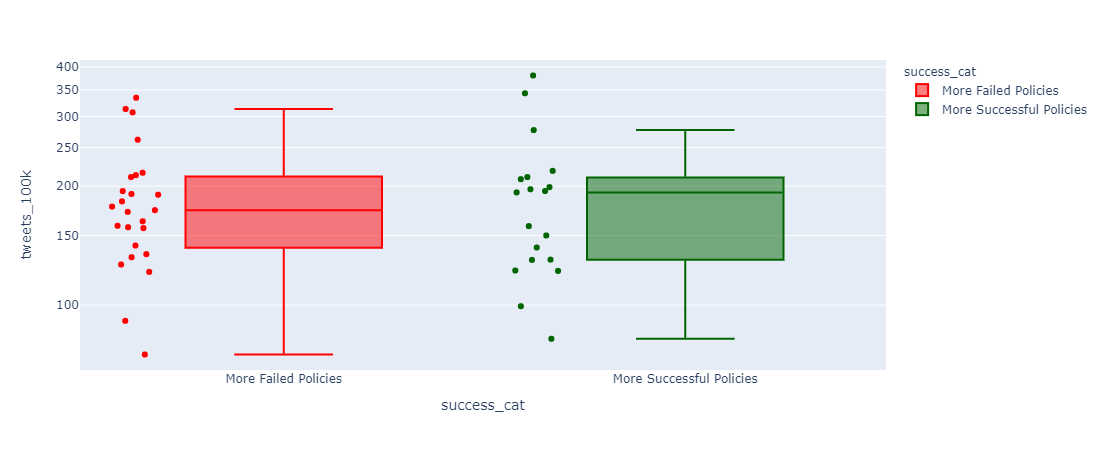

In [243]:
import plotly.express as px
var = "tweets_100k"
px.box(state_tp_stat_out[(state_tp_stat_out['success_cat']!="")&(~state_tp_stat_out['state'].isin(["DE", "DC"]))], x = "success_cat", y=var, 
       hover_data=['state', var, 'policy_success_rate'], color = 'success_cat', color_discrete_sequence = ['red', 'darkgreen'],
       points = "all", log_y=True)
# fig.add_trace(px.strip(x='success_cat', y='tweets_100k'))
# fig.show()

In [250]:
# sns.barplot(data = state_tp_stat_out[~state_tp_stat_out['state'].isin(["DE", "DC"])].sort_values("tweets_100k"), x="state", y="tweets_100k", hue="success_cat", dodge=False)

In [297]:
# soup = BeautifulSoup(open(fr"C:/Users/Leonardo/OneDrive/Documents/TU_Delft/CodingProjects/PoliceBrutality/data/raw/NCLS/2020_policies.html"), "html.parser")
#     # clean html and convert policies to list of strings
# policies = soup.find_all('div', id = "dnn_ctr93953_StateNetDB_linkList")[0].text.split('\n')

In [296]:
# policies_str = list(filter(None,[el.replace('  ','') for el in list(filter(None, policies))]))
# policies_str_cl = [el for el in policies_str if "Text Lookup" not in el]
# print("There were", len([policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']), "state policies related to policing in 2021.")

In [193]:
# state_abbrv = [state.abbr for state in us.STATES]

In [295]:
# len([el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20])

In [289]:
# # extract all info of interest
# # policy_id = [el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# policy_id = [policies_str_cl[i-3] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# # state = [el[:2] for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# state = [el[:2] for el in policy_id]
# year = [el for el in policies_str_cl if el.startswith("2021") or el.startswith("2020")]
# status = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# DOLA = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Date of Last Action:*\xa0']
# author = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Author:']
# topics = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Topics: ']
# summary = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Summary: ']
# history = [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']

# df_data = {"policy_id": policy_id, "state": state, "year": year, "status": status, 
#            "date_of_last_action": DOLA, "author": author, "topics": topics, "summary": summary, "history": history}

# df_policies = pd.DataFrame.from_dict(df_data)

In [290]:
# policies_str_cl[:100]

In [291]:
# [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']